<a href="https://colab.research.google.com/github/Hugo-magalhaes/Basic_django_blog/blob/main/DataMaster_Hugo_MM_Junior_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.0 🎛️ Imports

In [1]:
!pip install findspark -qq
# !pip install pyspark -qq
# !pip install xgboost -qq

In [6]:
from google.colab import drive
import kagglehub
import os

import findspark

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import math
import pandas as pd
import numpy as np
from types import NoneType
from IPython.display import Image

from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.window import Window as W

from pyspark.ml.feature import VectorAssembler, Imputer
from pyspark.ml.classification import RandomForestClassifier, DecisionTreeClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.functions import vector_to_array

from xgboost.spark import SparkXGBClassifier

import warnings

warnings.filterwarnings('ignore')
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
findspark.init()

spark = (SparkSession.builder.master("local[*]").appName('Case01')
    # .config("spark.driver.memory", "6g")
    # .config("spark.executor.memory", "4g")
       # '*' significa: use todos os núcleos/CPUs disponíveis no ambiente
    .config("spark.executor.memory", "6g")
    .config("spark.driver.memory", "6g")
    \
    # 2. Configura o número de núcleos de CPU para processamento paralelo
    # 'local[*]' e 'spark.executor.cores'='4' usam paralelismo máximo.
    .config("spark.executor.cores", "4")
    .config("spark.driver.cores", "4")

    # 3. Otimizações de desempenho geral
    .config("spark.sql.shuffle.partitions", "200")
    .config("spark.default.parallelism", "100")
    .getOrCreate())

path = kagglehub.dataset_download('gcenachi/case-data-master-2024')

print(path)

Using Colab cache for faster access to the 'case-data-master-2024' dataset.
/kaggle/input/case-data-master-2024


In [4]:
# for root, dirs, files in os.walk(path):
#     for file in files:
#           file_path = os.path.join(root, file)
#           print(file_path)

In [5]:
transactions = spark.read.parquet(f'{path}/transactions.parquet')

members = spark.read.parquet(f'{path}/members.parquet')

user_logs = spark.read.parquet(f'{path}/user_logs.parquet')

# 1. ⚙️ Funções

In [6]:
# Amostragem de cliente
def filtra_cliente(df, msno):
  filtered_df = df.filter(F.col('msno').like(f'{msno}%'))
  count = filtered_df.count()
  filtered_df.orderBy('safra').show(count)

# Calcula % de nulos
def avalia_nulos(df, total:int):
  for col in df.columns:
    nulos = (df.filter((F.col(col).isNull())).count())
    print(f'{col} tem {(nulos/total):.2%} nulos')

  print()

# Calcula quantidade de distintos
def avalia_distintos(df):

  cols_avalia = []

  for col in df.columns:
    distinct_count = df.select(col).distinct().count()
    print(f"{col} : {distinct_count:,} valores distintos")

    if distinct_count > 2 and distinct_count < 100:
      cols_avalia.append(col)

  print()
  return cols_avalia

# Trata as datas para que consigam ser transformadas corretamente
def date_transform(col:str):
  return F.to_date(F.concat(
                      F.substring(F.col(col),1,4),F.lit('-'),
                      F.substring(F.col(col),5,2),F.lit('-'),
                      F.substring(F.col(col),7,2)
                      ))

# 2. 📘 Avaliando as malhas

Base Transactions <br>

msno - id  <br>
payment_method_id - Forma de pagamento <br>
payment_plan_days - Tipo de plano por tempo (mensal, semestral e etc) <br>
plan_list_price - Lista de preço dos planos NTD (1 real para 5,53 NTD's) <br>
actual_amount_paid - Valor pago atualmente NTD <br>
is_auto_renew - Renovação automática <br>
transaction_date - Data da transação <br>
membership_expire_date - Date de expiração do membro (Prazo do plano se não for renovação automática ?) <br>
is_cancel - Cancelou o plano neste pagamento <br>
safra - safra <br>
<br>
Base members <br>

msno - id <br>
safra - safra <br>
registration_init_time <br>
city - cidade do cliente <br>
bd - age <br>
gender - genêro do cliente <br>
registered_via - canal de registro <br>
is_ativo - cliente ativo <br>
<br>
Base user logs <br>

msno - id <br>
safra - safra <br>
num_25 - ouviu até 25% da música<br>
num_50 - ouviu entre 25% e 50% da música <br>
num_75 - ouviu entre 25% e 75% da música <br>
num_985 - ouviu entre 75% e 98,5% da música <br>
num_100 - ouviu acima de 98,5% da música <br>
num_unq - quantidade de músicas escutadas <br>
total_secs - total de segundos escutados <br>


In [8]:
transactions.printSchema(), members.printSchema(), user_logs.printSchema()


root
 |-- msno: string (nullable = true)
 |-- payment_method_id: string (nullable = true)
 |-- payment_plan_days: string (nullable = true)
 |-- plan_list_price: string (nullable = true)
 |-- actual_amount_paid: string (nullable = true)
 |-- is_auto_renew: string (nullable = true)
 |-- transaction_date: string (nullable = true)
 |-- membership_expire_date: string (nullable = true)
 |-- is_cancel: string (nullable = true)
 |-- safra: integer (nullable = true)

root
 |-- msno: string (nullable = true)
 |-- safra: string (nullable = true)
 |-- registration_init_time: string (nullable = true)
 |-- city: string (nullable = true)
 |-- bd: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- registered_via: string (nullable = true)
 |-- is_ativo: integer (nullable = true)

root
 |-- msno: string (nullable = true)
 |-- safra: integer (nullable = true)
 |-- num_25: double (nullable = true)
 |-- num_50: double (nullable = true)
 |-- num_75: double (nullable = true)
 |-- num_985: do

(None, None, None)

In [13]:
# Tratamento nas colunas da transactions
transactions_p = (transactions.withColumn("payment_plan_days", F.col("payment_plan_days").cast('int'))
                            .withColumn("plan_list_price", F.col("plan_list_price").cast('float'))
                            .withColumn("actual_amount_paid", F.col("actual_amount_paid").cast('float'))
                            .withColumn("is_auto_renew", F.col("is_auto_renew").cast('int'))
                            .withColumn("is_cancel", F.col("is_cancel").cast('int'))
                            .withColumn("transaction_date",date_transform('transaction_date'))
                            .withColumn("membership_expire_date",date_transform('membership_expire_date'))
              )

ativo_m3 = F.lead('is_ativo',3).over(W.partitionBy('msno').orderBy('safra'))

# Tratamento nas colunas da members
members_p = (members.withColumn("safra", F.col("safra").cast('int'))
                  .withColumn("registration_init_time", date_transform('registration_init_time'))
                  .withColumn("bd", F.col("bd").cast('int'))
                  .withColumn("gender", F.col("gender").cast('string'))
                  .withColumn('declared_gender', F.when(F.col('gender').isNull(), 0).otherwise(1))
                  .withColumn('churn_m3', F.when((ativo_m3.isin(0)) & (F.col('is_ativo').isin(1)), 1)
                                            .otherwise(0)
                              )
                  .withColumn('churn_origem', F.when((F.col('is_ativo').isin(0)) & (ativo_m3.isin(0) | ativo_m3.isNull()), 1)
                                            .otherwise(0)
                              )
                  # .withColumn('pseudo_churn', F.when((F.col('is_ativo').isin(1)) & (ativo_m3.isNull()), 1)
                  #                           .otherwise(0))
                  )
# Tratamento das colunas user_logs
user_logs_p = (user_logs
               )

# Matendo apenas os meses com tempo suficiente para análise
members_churn = members_p.filter((F.col('safra')<=201609) & F.col('churn_origem').isin(0))

# Juntando todas as bases
full_df = members_churn.join(transactions_p, on=['msno', 'safra'], how='left').join(user_logs_p, on=['msno', 'safra'], how='left')


#Tratando as bases
full_df_p = (full_df.withColumn('info_transaction', F.when(F.col('payment_method_id').isNull(), 0).otherwise(1))
                  .withColumn('info_user_logs', F.when(F.col('num_unq').isNull(), 0).otherwise(1))
             )

# Quebrando a base treino (70%), teste (30%) de 201601-201606 e OOT 201607-201609
# Considerando que temos apenas 9 meses para avaliaçãod e churn, os 3 primeiros meses não podem ser inferidos como outliers, e portanto, serão tratados como sazonalidade
# Quedas abruptas de ~5% por mês durante os 3 meses, basta um mês com a mesma variação para voltarmos a patamares próximos de churn

#Pela lei dos grandes números, uma parcela da amostra de treino deve ser suficiente para avaliar todas as situações de tratamento e feature engineering

malha_final_orig = full_df_p.sample(fraction=0.3, seed=42)
full_df_train_orig, full_df_test_orig = malha_final_orig.filter(F.col('safra').between(201601, 201606)).randomSplit([0.8, 0.2], seed=42)
full_df_oot_orig = malha_final_orig.filter(F.col('safra').between(201607,201609))

In [ ]:
full_df_train_orig.write.mode("overwrite").parquet('/content/drive/MyDrive/df_analysis_orig.parquet')

In [93]:
df_analysis = spark.read.parquet('/content/drive/MyDrive/df_analysis_orig.parquet')

In [ ]:
total_transactions = transactions.count()
total_members = members.count()
total_user_logs = user_logs.count()

print(f'{total_transactions=:,} | {total_members=:,} | {total_user_logs=:,}')

total_transactions=20,712,225 | total_members=63,867,246 | total_user_logs=26,758,971


In [ ]:
total_churn = members_churn.filter(F.col('churn_m3').isin(1)).count()
total_ativos = members_churn.filter(F.col('is_ativo').isin(1)).count()

# total_novos_clientes = members_p.filter(F.col('cliente_novo').isin(1)).count()
# total_novos_clientes=1,109,682

print(f'{total_churn=:,} | {total_ativos=:,}')
print(f'churn {(total_churn/total_ativos)*100:.2f}%')

total_churn=1,148,026 | total_ativos=8,144,396
churn 14.10%


In [ ]:
total_churn1 = members_churn.filter(F.col('churn_m3').isin(1)&F.col('safra').between(201601,201606)).count()
total_ativos1 = members_churn.filter(F.col('is_ativo').isin(1)&F.col('safra').between(201601,201606)).count()

print(f'{total_churn1=:,} | {total_ativos1=:,}')
print(f'churn {(total_churn1/total_ativos1)*100:.2f}%')

total_churn1=790,635 | total_ativos1=5,204,532
churn 15.19%


In [ ]:
n_churn_analysis = df_analysis.filter(F.col('churn_m3').isin(0)).count()
churn_analysis = df_analysis.filter(F.col('churn_m3').isin(1)).count()
ativos_analysis = df_analysis.filter(F.col('is_ativo').isin(1)).count()

print(f'{churn_analysis=:,} | {ativos_analysis=:,} | {n_churn_analysis=:,}')
print(f'churn {(churn_analysis/ativos_analysis)*100:.2f}%')

churn_analysis=190,166 | ativos_analysis=1,249,160 | n_churn_analysis=1,224,953
churn 15.22%


In [ ]:
transactions.show(10)

members.show(10)

user_logs.show(10)

+--------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+
|                msno|payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel| safra|
+--------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+
|+++IZseRRiQS9aaSk...|               38|              410|           1788|              1788|            0|        20151121|              20170104|        0|201511|
|+++snpr7pmobhLKUg...|               41|               30|            149|               149|            1|        20150526|              20150626|        0|201505|
|+++snpr7pmobhLKUg...|               41|               30|            149|               149|            1|        20150926|              20151026|        0|201509|
|++/9R3sX3

In [ ]:
members.select(F.min(F.col('safra')), F.max(F.col('safra')))
# +----------+----------+
# |min(safra)|max(safra)|
# +----------+----------+
# |    201601|    201612|
# +----------+----------+

transactions.select(F.min(F.col('safra')), F.max(F.col('safra')))
# +----------+----------+
# |min(safra)|max(safra)|
# +----------+----------+
# |    201501|    201702|
# +----------+----------+

user_logs.select(F.min(F.col('safra')), F.max(F.col('safra')))
# +----------+----------+
# |min(safra)|max(safra)|
# +----------+----------+
# |    201501|    201702|
# +----------+----------+

In [ ]:
cols_transactions = avalia_distintos(transactions)
# msno : 2,363,626 valores distintos
# payment_method_id : 40 valores distintos
# payment_plan_days : 37 valores distintos
# plan_list_price : 51 valores distintos
# actual_amount_paid : 57 valores distintos
# is_auto_renew : 2 valores distintos
# is_cancel : 2 valores distintos
# safra : 26 valores distintos

cols_members = avalia_distintos(members)
# msno : 6,287,789 valores distintos
# safra : 12 valores distintos
# city : 21 valores distintos
# bd : 385 valores distintos
# gender : 3 valores distintos
# registered_via : 17 valores distintos
# is_ativo : 2 valores distintos
# churn : 2 valores distintos

cols_user_logs = avalia_distintos(user_logs)
# msno : 5,234,111 valores distintos
# safra : 26 valores distintos
# num_25 : 4,891 valores distintos
# num_50 : 1,587 valores distintos
# num_75 : 986 valores distintos
# num_985 : 2,509 valores distintos
# num_100 : 13,047 valores distintos
# num_unq : 8,593 valores distintos
# total_secs : 24,025,199 valores distintos

In [ ]:
print(f'{transactions_p.dropDuplicates().count():,}')
# 20,712,225 Sem duplicidade

print(f'{user_logs.dropDuplicates().count():,}')
# 26,758,971 Sem duplicidade

total_nodup = members.dropDuplicates().count()
# total_nodup = 63,867,246 Sem duplicidade

In [ ]:
total_transactions = avalia_nulos(transactions_p, total_transactions)
# msno tem 0.00% nulos
# payment_method_id tem 0.00% nulos
# payment_plan_days tem 0.00% nulos
# plan_list_price tem 0.00% nulos
# actual_amount_paid tem 0.00% nulos
# is_auto_renew tem 0.00% nulos
# transaction_date tem 0.00% nulos
# membership_expire_date tem 0.00% nulos
# is_cancel tem 0.00% nulos
# safra tem 0.00% nulos

total_members = avalia_nulos(members_p, total_members)
# msno tem 0.00% nulos
# safra tem 0.00% nulos
# registration_init_time tem 0.00% nulos
# city tem 0.00% nulos
# bd tem 0.00% nulos
# gender tem 59.83% nulos
# registered_via tem 0.00% nulos
# is_ativo tem 0.00% nulos
# churn tem 0.00% nulos

total_user_logs = avalia_nulos(user_logs, total_user_logs)
# msno tem 0.00% nulos
# safra tem 0.00% nulos
# num_25 tem 0.00% nulos
# num_50 tem 0.00% nulos
# num_75 tem 0.00% nulos
# num_985 tem 0.00% nulos
# num_100 tem 0.00% nulos
# num_unq tem 0.00% nulos
# total_secs tem 0.00% nulos

In [ ]:
avalia_nulos(full_df.select('gender', 'payment_method_id', 'num_unq'), full_df.count())

# gender tem 46.33% nulos
# payment_method_id tem 27.47% nulos
# num_unq tem 16.44% nulos

In [ ]:
transactions_p.filter(F.col('membership_expire_date')<'2010-01-01').show()

# +--------------------+------+----------------------+------------------+---------------+------------------+-----
# |                msno| safra|registration_init_time| payment_plan_days|transaction_date|membership_expire_date|
# |WJGws9POS4KSuory4...|201604|            2011-09-11|               180|      2016-04-03|            1970-01-01|
# |SJ7saWNc+Tuh6lZn5...|201601|            2011-12-18|                30|      2016-01-22|            2005-11-26|
# |MWtzIv/G94QDbDcIF...|201603|            2012-12-10|               180|      2016-03-22|            1970-01-01|
# |J+duJ7q0kFSkjldna...|201604|            2006-11-20|                30|      2016-04-19|            1970-01-01|

transactions_p.filter(F.col('membership_expire_date')<F.col('transaction_date')).count()
# 105572

In [ ]:
(full_df_p.groupBy('registered_via').count())

# +--------------+-------+
# |registered_via|  count|
# +--------------+-------+
# |             7|3923885|
# |             3|1507665|
# |             9|3185940|
# |             4| 562465|
# |            13|    911|
# |            10|     11|
# |            16|      1|
# +--------------+-------+

In [ ]:
(members_churn.groupBy('safra').agg(F.sum('churn_m3').alias('churn'),
                                    F.sum('is_ativo').alias('ativos'),
                                    F.sum('churn_origem').alias('churn_origem'),
                                    F.count('*').alias('total'),
                                    ))

# +------+------+------+------------+-------+
# | safra| churn|ativos|churn_origem|  total|
# +------+------+------+------------+-------+
# |201609|128945|991285|     4723876|5778986|
# |201604| 88724|831565|     3882224|4876301|
# |201603|136674|871651|     3766018|4697972|
# |201607|105263|967936|     4350332|5439337|
# |201606| 97050|844884|     4221578|5250064|
# |201601|183246|888663|     3345327|4294184|
# |201605|100246|849653|     4045688|5060705|
# |201608|123183|980643|     4476488|5615921|
# |201602|184695|918116|     3523415|4502354|
# +------+------+------+------------+-------+

In [ ]:
churn  = (members_churn.groupBy('safra').agg(F.count('*').alias('total')
                              , F.sum(F.col('churn_m3')).alias('churn_m3')
                              # , F.sum(F.col('cliente_novo')).alias('clientes_novos')
                              , F.sum(F.col('is_ativo')).alias('ativos')
                              )
.withColumn('pct_churn_m3', F.round(F.col('churn_m3')/F.col('ativos'),3))
 .orderBy('safra'))

churn_pd = churn.select('safra', 'pct_churn_m3').toPandas()

In [ ]:

fig = px.line(churn_pd, x='safra', y='pct_churn_m3', text='pct_churn_m3', title='Churn Rate por Safra')

fig.update_traces(texttemplate='%{text:.2%}', textposition='top center')

fig.update_layout(
    xaxis_title='Safra',
    yaxis_title='Taxa de Churn',
    # plot_bgcolor='white',
    # paper_bgcolor='white',
    yaxis = dict(tickformat = '.2%', showgrid=False, zeroline=False),
    xaxis = dict(tickformat = 'str', showgrid=False, zeroline=False),
    showlegend=True,
    width=900,  # Largura ligeiramente menor que 794px para margens
    height=450, # Altura ligeiramente menor que 1123px para margens
)

fig.show()

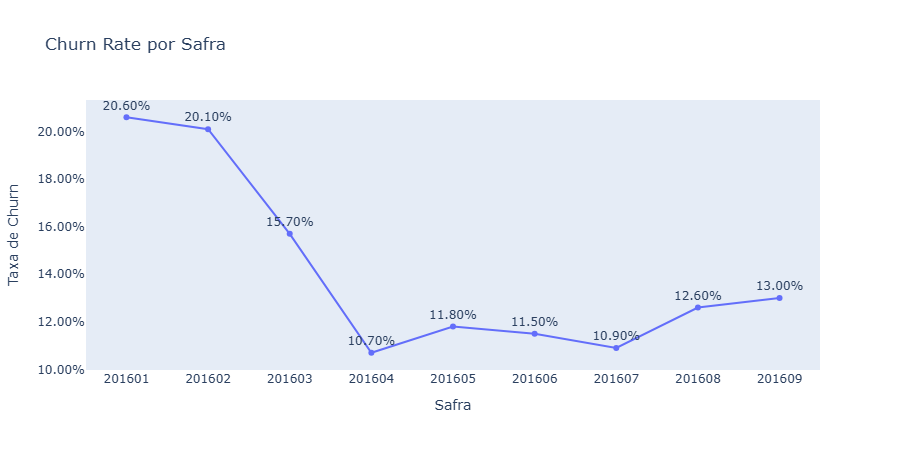

In [5]:
Image('/content/plot churn total.png')

In [ ]:
churn_analysis_graph = (df_analysis.groupBy('safra')
                  .agg(F.sum('is_ativo').alias('ativos')
                      ,F.sum('churn_m3').alias('churn')
                      ,F.count('*').alias('total'))
                  .withColumn('pct_churn', F.round(F.col('churn')/F.col('ativos'),3))
                  .orderBy('safra')
                  )

churn_analysis_df = churn_analysis_graph.toPandas()

fig = px.line(churn_analysis_df, x='safra', y='pct_churn', text='pct_churn', title='Churn Rate por Safra')

fig.update_traces(texttemplate='%{text:.2%}', textposition='top center')

fig.update_layout(
    xaxis_title='Safra',
    yaxis_title='Taxa de Churn',
    # plot_bgcolor='white',
    # paper_bgcolor='white',
    yaxis = dict(tickformat = '.2%', showgrid=False, zeroline=False),
    xaxis = dict(tickformat = 'str', showgrid=False, zeroline=False),
    showlegend=True,
    width=900,  # Largura ligeiramente menor que 794px para margens
    height=450, # Altura ligeiramente menor que 1123px para margens
)

fig.show()

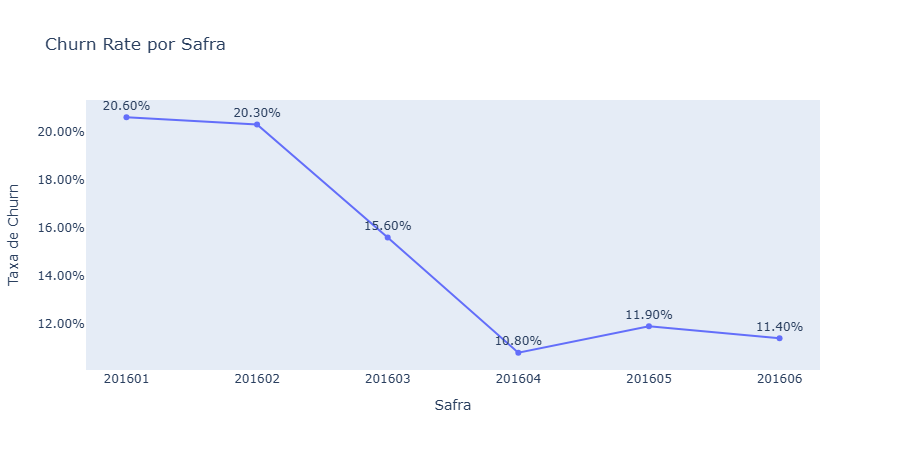

In [7]:
Image('/content/plot churn amostra.png')

In [ ]:
# A taxa de cancelamento x churn é muito alta, por isso é leakege
(full_df_p.filter(F.col('churn_origem').isin(0))
          .groupBy('is_cancel')
          .agg(F.sum(F.col('is_ativo')).alias('ativos'),
               F.sum('churn_m3').alias('churns'))
          .withColumn('pct_churn', F.round(F.col('churns')/F.col('ativos'),2))
          ).show()

+---------+-------+------+---------+
|is_cancel| ativos|churns|pct_churn|
+---------+-------+------+---------+
|     NULL|1485647|461762|     0.31|
|        1| 149200|105932|     0.71|
|        0|6509549|580332|     0.09|
+---------+-------+------+---------+



In [ ]:
# A taxa não é tão alta para renovação 0, então não é leakege
(full_df_p.filter(F.col('churn_origem').isin(0))
          .groupBy('is_auto_renew')
          .agg(F.sum(F.col('is_ativo')).alias('ativos'),
               F.sum('churn_m3').alias('churns'))
          .withColumn('pct_churn', F.round(F.col('churns')/F.col('ativos'),2))
          ).show()

+-------------+-------+------+---------+
|is_auto_renew| ativos|churns|pct_churn|
+-------------+-------+------+---------+
|         NULL|1485647|461762|     0.31|
|            1|5619350|360280|     0.06|
|            0|1039399|325984|     0.31|
+-------------+-------+------+---------+



# 3. 🏘️ Análise de categóricas

## Genêro

% de nulos de genêro vem aumentando ao longo do tempo. Apesar de discriminar melhor o clientes inativos, são os clientes que não declaram

In [ ]:
(members.groupBy('safra').agg(
    (F.round(F.sum(F.when(F.col('gender').isNull(),1))/F.count('*'),2)).alias('pct_nulos')
    ).orderBy('safra'))

# +------+---------+
# | safra|pct_nulos|
# +------+---------+
# |201601|     0.53|
# |201602|     0.55|
# |201603|     0.56|
# |201604|     0.57|
# |201605|     0.58|
# |201606|     0.59|
# |201607|      0.6|
# |201608|     0.61|
# |201609|     0.62|
# |201610|     0.63|
# |201611|     0.63|
# |201612|     0.64|
# +------+---------+

In [ ]:
(members_p.groupBy('gender').agg(
    (F.round(F.sum(F.col('churn_m3'))/F.sum('is_ativo'),2)).alias('pct_churn')
    ))

# +------+---------+
# |gender|pct_churn|
# +------+---------+
# |  NULL|     0.07|
# |female|     0.13|
# |  male|     0.13|
# +------+---------+

In [ ]:
(members_p.groupBy('gender', 'safra').agg(
    (F.round(F.sum(F.col('churn_m3'))/F.sum('is_ativo'),2)).alias('pct_churn'))
    .groupBy('safra')
    .pivot('gender')
    .agg(F.first('pct_churn'))
    .orderBy('safra'))

# +------+----+------+----+
# | safra|null|female|male|
# +------+----+------+----+
# |201601|0.14|  0.26|0.25|
# |201602|0.12|  0.26|0.26|
# |201603|0.12|  0.19|0.19|
# |201604|0.08|  0.14|0.13|
# |201605|0.08|  0.15|0.15|
# |201606|0.08|  0.15|0.15|
# |201607|0.08|  0.13|0.14|
# |201608|0.09|  0.15|0.16|
# |201609| 0.1|  0.16|0.16|
# +------+----+------+----+

## Demais categóricas WoE e IV

IV < 0.02: não é útil <br>
0.02 ≤ IV < 0.1: baixo poder preditivo <br>
0.1 ≤ IV < 0.3: moderado poder preditivo <br>
0.3 ≤ IV < 0.5: alto poder preditivo <br>
IV ≥ 0.5: suspeito

### Imports

Agrupa contínuas - Cria faixas entre positivo, negativo e zero <br>
Agrupa quartils - Cria faixas de quartil <br>
Trata nulos - identifica o tipo da variável e substitui o nulo para verificar se o nulo tem informação relevante <br>
analisa WoE - Calcula Weight of Evidence e Information value para coluna especificada <br>
gera subsplots iv e Woe - Plota em conjunto todas as variáveis analisadas com WoE e IV <br>

In [88]:
# Cria um agrupamento das colunas com valores que não deveriam ser negativos
def agrupa_continuas(col:str):
  return( F.when(F.col(col) > 0, 'Positivo')
          .when(F.col(col) == 0, 'Neutro')
          .when(F.col(col) < 0, 'Negativo')
          .otherwise(F.lit(None))
          )

# Cria agrupamento de contínuas por quartis
def agrupa_quartils(col:str, quantiles:list[float]):
  return( F.when(F.col(col) <= quantiles[0], f'<= q1 {quantiles[0]:.2f}')
          .when(F.col(col) <= quantiles[1], f'<= q2 {quantiles[1]:.2f}')
          .when(F.col(col) <= quantiles[2], f'<= q3 {quantiles[2]:.2f}')
          .when(F.col(col) > quantiles[2], '> q3')
          .otherwise(F.lit(None))
          )

# Para plotar e verificar ganho de informação dos valores nulos
def trata_nulos(df, col:str):
  df_pd = df.toPandas()

  if isinstance(df_pd[col][0], (str, NoneType)):
    df_pd[col] = df_pd[col].fillna('nulo')
  else:
    df_pd[col] = df_pd[col].fillna(-1)

  return df_pd

# Calcula IV e WoE das variáveis
def analisa_Woe(df, col:str):
  df = (df.groupBy(col)
  .agg(
    F.sum(F.col('churn_m3')).alias('churn')
    ,F.sum(F.when(F.col('churn_m3').isin(0),1)).alias('n_churn')
    ,F.sum(F.col('is_ativo')).alias('ativo')
    )
    .withColumn('pct_churn', F.round(F.col('churn')/F.col('ativo'),4))
    .withColumn('good_dist', (F.col('n_churn')/n_churn_analysis))
    .withColumn('bad_dist', (F.col('churn')/churn_analysis))
    .withColumn('Woe', F.round(F.log((F.col('good_dist'))/(F.col('bad_dist'))),4))
    .withColumn('IV', F.round((F.col('good_dist') - F.col('bad_dist'))*F.col('Woe') ,4))

    .select(col, 'pct_churn', 'Woe', 'IV')
    .orderBy('Woe'))

  df_pd = trata_nulos(df, col)

  return df_pd

# Gera gráficos de WoE e IV
def gera_subplots_woe_iv(list_of_dfs_woe_iv, num_cols=2):
    # Extrair os nomes das colunas a partir dos DataFrames na lista
    cols_to_plot = [df.columns[0] for df in list_of_dfs_woe_iv]

    num_cols = num_cols  # Número desejado de colunas de subplots por linha
    num_rows = math.ceil(len(cols_to_plot) / num_cols)

    subplot_titles = [
    f'{df.columns[0]} com IV {df["IV"].sum():.2f}'
    for df in list_of_dfs_woe_iv
                    ]

    fig = make_subplots(rows=num_rows, cols=num_cols,
                        subplot_titles=subplot_titles,
                        specs=[[{"secondary_y": True}] * num_cols] * num_rows) # Habilitar eixo Y secundário para cada subplot

    for i, df_col in enumerate(list_of_dfs_woe_iv):
        col = df_col.columns[0] # Nome da coluna da variável no DataFrame atual

        row = math.floor(i / num_cols) + 1
        col_idx = (i % num_cols) + 1

        # Adicionar trace de linha para WoE
        # Trace de linha para WoE (eixo primário)
        fig.add_trace(
            go.Scatter(
                x=df_col[col],
                y=df_col['Woe'],
                # name=f'WoE ({col})',
                mode='lines+markers+text',
                text=df_col['Woe'],
                texttemplate='%{text:.2f}',
                marker_color='#2784F5',
                textposition="top center",
                showlegend=False if i > 0 else True
                      ),
            row=row,
            col=col_idx,
            secondary_y=False
        )

        # Trace de barra para IV (eixo secundário)
        fig.add_trace(
            go.Bar(
                x=df_col[col],
                y=df_col['IV'],
                # name=f'IV ({col})',
                textposition="auto",
                text=df_col['IV'],
                marker_color='#F54927',
                opacity=0.6,
                showlegend=False if i > 0 else True
                  ),
            row=row,
            col=col_idx,
            secondary_y=True
        )


        # Atualizar layout dos eixos para cada subplot
        fig.update_xaxes(title_text=col, showgrid=False, zeroline=False, row=row, col=col_idx)
        fig.update_yaxes(title_text="WoE", showgrid=False, zeroline=False, row=row, col=col_idx, secondary_y=False)
        fig.update_yaxes(title_text="IV", showgrid=False, zeroline=False, row=row, col=col_idx, secondary_y=True)

    # Atualizar layout geral
    fig.update_layout(
        title_text="Análise de WoE e IV por Variável",
        # showlegend=True,
        bargap=0.3,
        # autosize=False,
        width=900, # Ajustar largura
        height=num_rows * 400, # Ajustar altura
    )

    fig.show()

In [ ]:
# Cidade tem poder moderado, apenas irei reunir as categorias para reduzir cardinalidade mantendo apenas as cidades com alto poder discriminativo e novas cidades
# Declared_gender e gender tem o mesmo poder preditivo quando se utilizam o nulo, pretendo manter em formato numérico ambas
# payment method muita cardinalidade e um poder preditivo estranho, agrupar o máximo que puder
# registered_via tem bom poder preditivo, portanto, irei trocar cada por ser valor WOe e Null para novos e o 10
# is_auto_renew tem alto poder preditivo por suas próprias classes, irei preencher os nulos com zeros para ver o que temos

# Os manterei apenas para estudos posteriores
# Não ter informações de transação nos da mais poder preditivo, mas ainda baixo
# Com user logs é ao contrário, porém irrelevante
cols_cat = ['city', 'declared_gender', 'gender', 'payment_method_id', 'registered_via', 'is_auto_renew', 'is_cancel', 'info_transaction', 'info_user_logs']
dfs_cat = []
for col in cols_cat:
  dfs_cat.append(analisa_Woe(df_analysis, col))

gera_subplots_woe_iv(dfs_cat, 3)


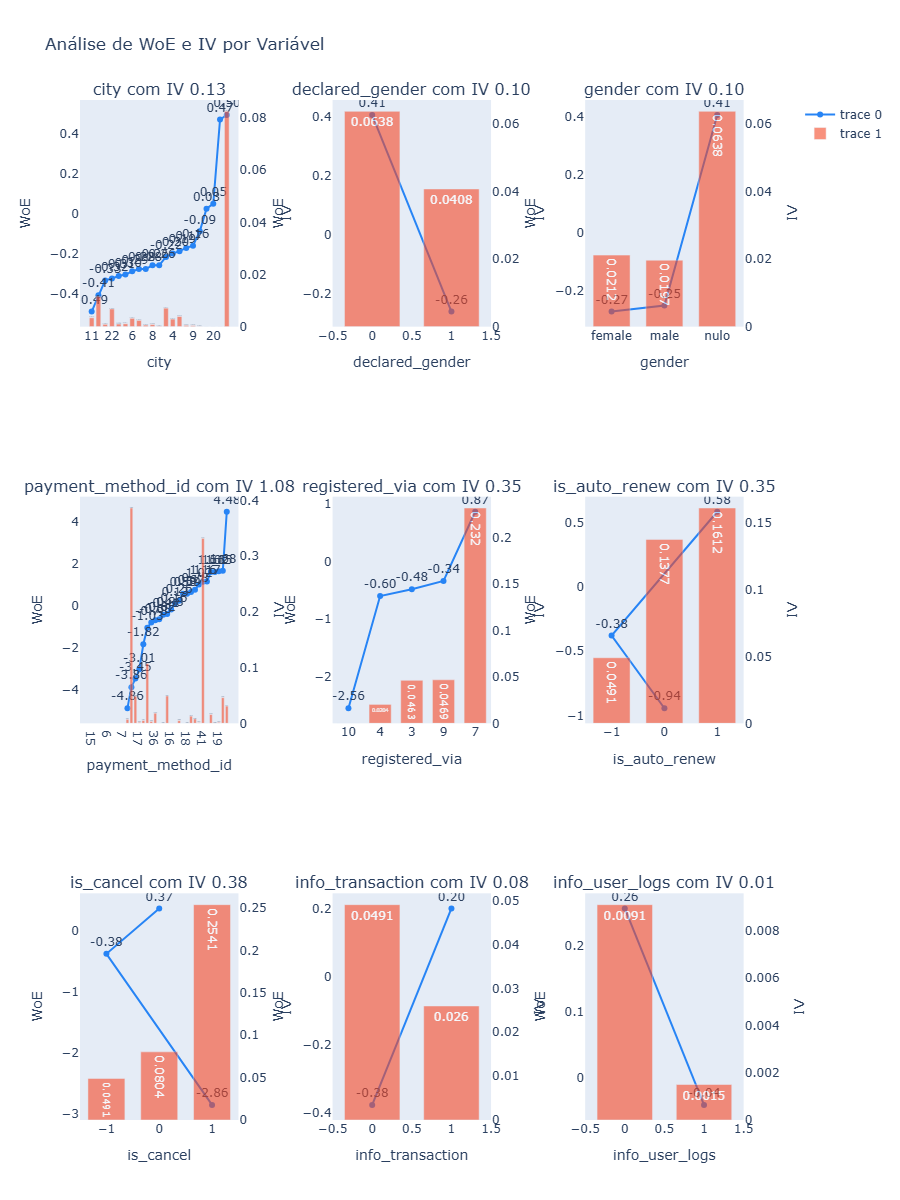

In [10]:
Image('/content/plot orig cat.png')

In [ ]:
total_rows = df_analysis.count()

(df_analysis.groupBy('payment_method_id').count()
.withColumn('dist', F.round(F.col('count')/total_rows, 4))
.orderBy(F.col('count')).show(1000)
)

+-----------------+------+------+
|payment_method_id| count|  dist|
+-----------------+------+------+
|                2|     1|   0.0|
|                7|     2|   0.0|
|                3|    13|   0.0|
|                6|    18|   0.0|
|                8|    32|   0.0|
|               15|    60|   0.0|
|               10|    69|   0.0|
|               11|    96|1.0E-4|
|               26|   128|1.0E-4|
|               17|   150|1.0E-4|
|               12|   162|1.0E-4|
|               21|   256|2.0E-4|
|               13|   475|3.0E-4|
|               14|   753|5.0E-4|
|               16|   844|6.0E-4|
|               18|   870|6.0E-4|
|               22|   909|6.0E-4|
|               29|  1274|9.0E-4|
|               19|  1605|0.0011|
|               23|  2495|0.0018|
|               20|  2605|0.0018|
|               35|  3275|0.0023|
|               27|  3504|0.0025|
|               30|  3538|0.0025|
|               28|  6018|0.0042|
|               32|  8346|0.0059|
|             

In [94]:
# Para cidade irei juntar as cidades com Woe de 10% em 10% para diminuir e substituir pelo valor do Woe do grupo
# O método de pagamento tem um IV muito alto e não resolveu tratando, será descartado
# a renovação automática e cancelado com tratamento nulo perdeu poder preditivo, então manteremos o nulo

df_enconded = (df_analysis.withColumn('city_grouped', F.when(F.col('city').isin(11,15), -0.4226)
                                                        .when(F.col('city').isin(22, 18, 6, 17), -0.3279)
                                                        .when(F.col('city').isin(10, 14, 8, 7, 21, 13), -0.2271)
                                                        .when(F.col('city').isin(5, 4, 9, 12), -0.1808)
                                                        .when(F.col('city').isin(20, 3, 16), -0.0719)
                                                        .when(F.col('city').isin(19), 0.3652)
                                                        .when(F.col('city').isin(1), 0.4923)
                                                        .otherwise(0.000)
                                      )
                          .withColumn('pay_method_grouped', F.when(F.col('payment_method_id').isin(41), 1.1517)
                                                        # .when(F.col('payment_method_id').isin(21,39, 35, 17, 29, 38, 28, 36, 26, 30, 16), -1)
                                                        # .when(F.col('payment_method_id').isin(23, 41, 31, 34, 19, 14, 32, 40, 27, 11, 18, 10, 37, 33), 1)
                                                        # .when(F.col('payment_method_id').isin(21,39, 35, 17, 29, 38), -1)
                                                        # .when(F.col('payment_method_id').isin(23, 41, 31, 34, 19, 14, 32), -2)
                                                        # .when(F.col('payment_method_id').isin(28, 36), -3)
                                                        # .when(F.col('payment_method_id').isin(26, 30, 16), -4)
                                                        # .when(F.col('payment_method_id').isin(40, 27), -5)
                                                        # .when(F.col('payment_method_id').isin(11, 18, 10, 37, 33), -5)
                                                        .otherwise(F.lit(0.1141))
                                      )
                          .withColumn('registered_via_treated', F.when(F.col('registered_via').isin(4), -0.5939)
                                                                  .when(F.col('registered_via').isin(3), -0.4942)
                                                                  .when(F.col('registered_via').isin(9), -0.334)
                                                                  .when(F.col('registered_via').isin(7), 0.8601)
                                                                  .otherwise(0.0000)
                                      )
                          .withColumn('is_auto_renew_treated', F.when(F.col('is_auto_renew').isNull(), 0)
                                                                  .otherwise(F.col('is_auto_renew'))
                                      )
                          .withColumn('is_cancel_treated', F.when(F.col('is_cancel').isNull(), 0)
                                                                  .otherwise(F.col('is_cancel'))
                                      )

                          .withColumn('gender_treated', F.when(F.col('gender').isin('Male'), 1)
                                                                  .when(F.col('gender').isin('Female'), 0)
                                                                  .otherwise(F.lit(None))
                                      )
               )

In [ ]:
cols_cat_treated = ['city_grouped', 'pay_method_grouped', 'is_auto_renew_treated', 'is_cancel_treated']
dfs_cat_treated = []

for col in cols_cat_treated:
  dfs_cat_treated.append(analisa_Woe(df_enconded, col))
gera_subplots_woe_iv(dfs_cat_treated, 2)

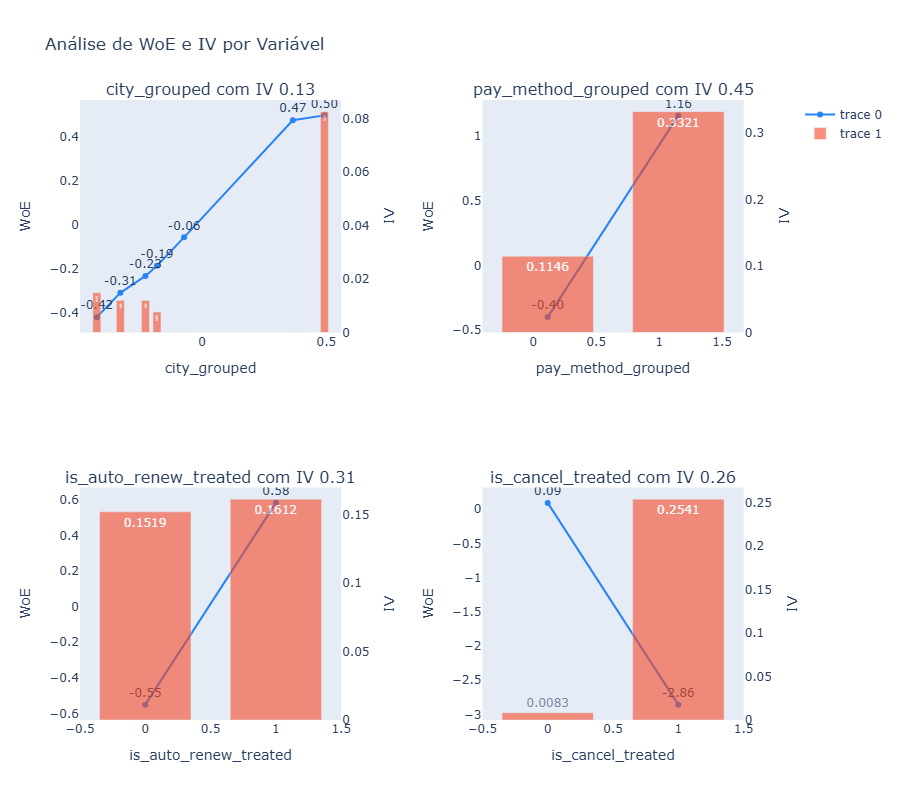

In [11]:
Image('/content/plot cat final.png')

Vemos também que o plan_days realmente se refere ao tipo do plano pelo tempo de renovação. Apesar de ter alguns valores outliers.

E mais abaixo, vemos que o valor atual pago e o valor do plano se conversam, porém existem valores zeros que podem dizer que o aplicativo de músiva tem plano gratuito . E o valor padrão da assinatura é de $149 por mês.

Vemos que a maioria das classes não tem representatividade suficiente a 1% do todo, portanto, devem ser tiradas ou agrupadas todas em outros


Transactions tem apenas dados a cada pagamento feito. Contudo, a consistência é um pouco suspeita, uma vez que, o primeiro cliente tem renovação automática, e pagou 0 reais um mês

# 4. 📈 Análise de Contínuas

Para as variáveis de tempo, inicialmente irei tratá-las para serem contínuas e poderem ser avaliadas

### Imports
gera_df_media - calcula em samples percentuais ou fixos da malha distribuições e frequências para cada variável sendo churn e não churn <br>
gera_subplot_media - gera o gráfico da média selecionada

In [95]:
# Separar o DataFrame em churn e no_churn
def gera_df_media(df, cols_to_avg:list[str], num_splits:int=None, batch:int=None):


  churn_pd = df[df['churn_m3'] == 1].copy()
  nchurn_pd = df[df['churn_m3'] == 0].copy()

  # Gerar splits aleatórios e calcular a média para cada split
  churn_random_splits_avg = []
  nchurn_random_splits_avg = []

  if num_splits:
    for i in range(num_splits):
        # Amostragem com substituição para obter splits de tamanho similar (ou sem substituição dependendo da necessidade)
        churn_sample = churn_pd.sample(frac=1/num_splits, replace=True, random_state=42 + i) # Usar seed diferente para cada amostra
        nchurn_sample = nchurn_pd.sample(frac=1/num_splits, replace=True, random_state=42 + i)

        # Calcular a média das colunas selecionadas para cada amostra
        churn_avg_row = churn_sample[cols_to_avg].mean().to_dict()
        nchurn_avg_row = nchurn_sample[cols_to_avg].mean().to_dict()

        # Adicionar a coluna 'churn_m3' para identificar o grupo
        churn_avg_row['churn_m3'] = 1
        nchurn_avg_row['churn_m3'] = 0

        churn_random_splits_avg.append(churn_avg_row)
        nchurn_random_splits_avg.append(nchurn_avg_row)

  elif batch:
    for i in range(0, churn_pd.shape[0], batch):
        # Amostragem com substituição para obter splits de tamanho similar (ou sem substituição dependendo da necessidade)
        churn_sample = churn_pd.iloc[i: i + batch] # Usar seed diferente para cada amostra
        nchurn_sample = nchurn_pd.iloc[i: i + batch]

        # Calcular a média das colunas selecionadas para cada amostra
        churn_avg_row = churn_sample[cols_to_avg].mean().to_dict()
        nchurn_avg_row = nchurn_sample[cols_to_avg].mean().to_dict()

        # Adicionar a coluna 'churn_m3' para identificar o grupo
        churn_avg_row['churn_m3'] = 1
        nchurn_avg_row['churn_m3'] = 0

        churn_random_splits_avg.append(churn_avg_row)
        nchurn_random_splits_avg.append(nchurn_avg_row)


  # Unir os resultados em DataFrames Pandas
  churn_all_pd = pd.DataFrame(churn_random_splits_avg)
  nchurn_all_pd = pd.DataFrame(nchurn_random_splits_avg)

  # Concatenar os DataFrames churn e no_churn
  return pd.concat([churn_all_pd, nchurn_all_pd])


def gera_subplot_media(df, cols_to_plot:list[str], num_cols:int=4):

  # Calcular o número de linhas e colunas para os subplots
  num_cols = num_cols  # Número desejado de colunas por linha
  num_rows = math.ceil(len(cols_to_plot) / num_cols)

  # Criar os subplots
  fig = make_subplots(rows=num_rows, cols=num_cols, subplot_titles=cols_to_plot)

  # Adicionar os histogramas para cada coluna
  for i, col in enumerate(cols_to_plot):
      row = math.floor(i / num_cols) + 1
      col_idx = (i % num_cols) + 1

      fig.add_trace(go.Histogram(x=df[df['churn_m3'] == 1][col],
                                histfunc='avg',
                                name='churn',
                                marker_color='#F54927',
                                showlegend=False if i > 0 else True) # Mostrar legenda apenas para o primeiro trace de cada grupo
                    , row=row, col=col_idx)

      fig.add_trace(go.Histogram(x=df[df['churn_m3'] == 0][col],
                                histfunc='avg',
                                name='no churn',
                                marker_color='#2784F5',
                                showlegend=False if i > 0 else True) # Mostrar legenda apenas para o primeiro trace de cada grupo
                    , row=row, col=col_idx)


  # Atualizar layout
  fig.update_layout(barmode='overlay',
                    title_text="Histogramas da Média por Coluna (Churn vs No Churn)",
                    height=900, # Ajustar altura com base no número de linhas
                    width=1000
                    )
  fig.update_traces(opacity=0.6)

  fig.show()

In [ ]:

def correlation_plot(df, cols_to_plot):
    corr = df[cols_to_plot].corr(method='spearman')
    fig = px.imshow(
        corr,
        text_auto=".2%",  # Display correlation values in cells as percentages with 2 decimal places
        aspect="auto",   # Adjust aspect ratio automatically
        color_continuous_scale="RdBu", # Choose a suitable colorscale (e.g., Red-Blue for correlation)
        title="Correlation Heatmap",
    )
    fig.show()

    return corr

In [96]:
# defini o tempo de registro em meses porque não temos data_carga das bases para uma definição precisa em dias
df_enc_dt = (df_enconded
                        .withColumn('months_registered', ((F.substring(F.col('safra').cast('string'),1,4).cast('int') - F.year(F.col('registration_init_time')))*12
                                                    + (F.substring(F.col('safra').cast('string'),5,2).cast('int') - F.month(F.col('registration_init_time')))).cast('bigint')
                                                    )
                        .withColumn('days_until_expire', F.date_diff(F.col('membership_expire_date'), F.col('registration_init_time')).cast('int'))
                        .withColumn('months_until_expire', F.months_between(F.col('membership_expire_date'), F.col('registration_init_time')).cast('bigint'))
                        .withColumn('payment_day', F.dayofmonth(F.col('transaction_date')))
                        .withColumn('total_mins', F.round(F.col('total_secs')/60,2))
                        .withColumn('discount', F.col('plan_list_price') - F.col('actual_amount_paid'))
                        .withColumn('pct_discount', F.lit(1)-F.round(F.col('actual_amount_paid')/F.col('plan_list_price'),2))
                        .withColumn('has_discount', F.when(F.round(F.col('actual_amount_paid')/F.col('plan_list_price'),2)<1.00, F.lit(1))
                                                     .otherwise(F.lit(0))
                        )
                        .drop('pay_method_grouped',
                              'payment_method_id', 'registered_via',
                               'churn_origem', 'city', 'is_auto_renew_treated',
                               'is_cancel_treated', 'gender')
             )

In [ ]:
cols_num = ['bd', 'payment_plan_days', 'plan_list_price'
        , 'actual_amount_paid', 'num_25', 'num_50'
        , 'num_75', 'num_985', 'num_100'
        , 'num_unq', 'total_secs', 'months_registered'
        , 'days_until_expire', 'months_until_expire'
        , 'payment_day', 'total_mins']

In [ ]:
df_enc_dt.select(*cols_num).summary().show()

+-------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+-----------------+--------------------+-----------------+------------------+-------------------+------------------+--------------------+------------------+--------------------+
|summary|                bd|payment_plan_days|   plan_list_price|actual_amount_paid|            num_25|            num_50|            num_75|           num_985|          num_100|          num_unq|          total_secs|months_registered| days_until_expire|months_until_expire|       payment_day|          total_mins|          discount|        pct_discount|
+-------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+-----------------+--------------------+-----------------+------------------+-------------------+----------------

In [ ]:
quartils = {}
for col in cols_num:
  quartils[col] = df_enc_dt.approxQuantile(col, [0.25, 0.5, 0.75], 0.0)


In [ ]:
# Os valores negativos devem ser problemas sistêmicos, eles não trazem mais informação, portanto, bd será tratada como 0 e total_secs como nulo
# Os months_until_expired também não traz informação, mas com transaction_date e plan_days podemos estimar a data correta
cols_neg = ['bd', 'total_secs', 'months_until_expire']
dfs_neg = []
for col in cols_neg:
  df_trata = df_enc_dt.withColumn('cat_' + col, agrupa_continuas(col))
  dfs_neg.append(analisa_Woe(df_trata, 'cat_' + col))
gera_subplots_woe_iv(dfs_neg, 3)

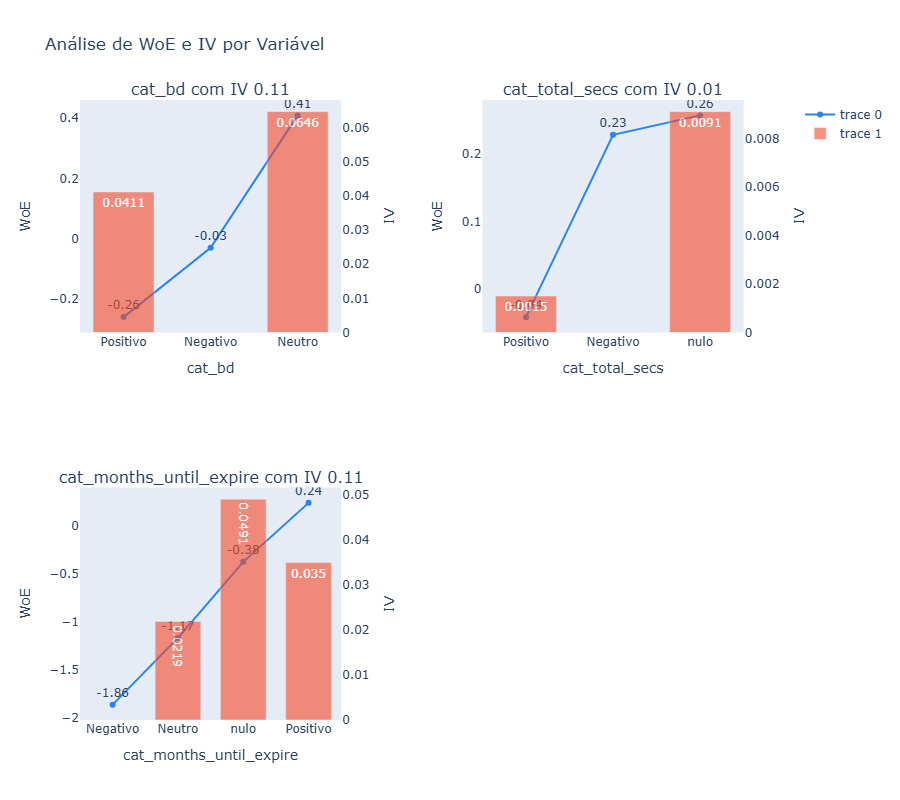

In [12]:
Image('/content/plot neg num.png')

In [ ]:
# Os valores negativos devem ser prblemas sistêmicos, eles não trazem mais informação, portanto, bd será tratada como 0 e total_secs como nulo
dfs_num = []

for col in cols_num:
  df_trata = df_enc_dt.withColumn('quartil_' + col, agrupa_quartils(col, quartils[col]))
  dfs_num.append(analisa_Woe(df_trata, 'quartil_' + col))
gera_subplots_woe_iv(dfs_num, 3)


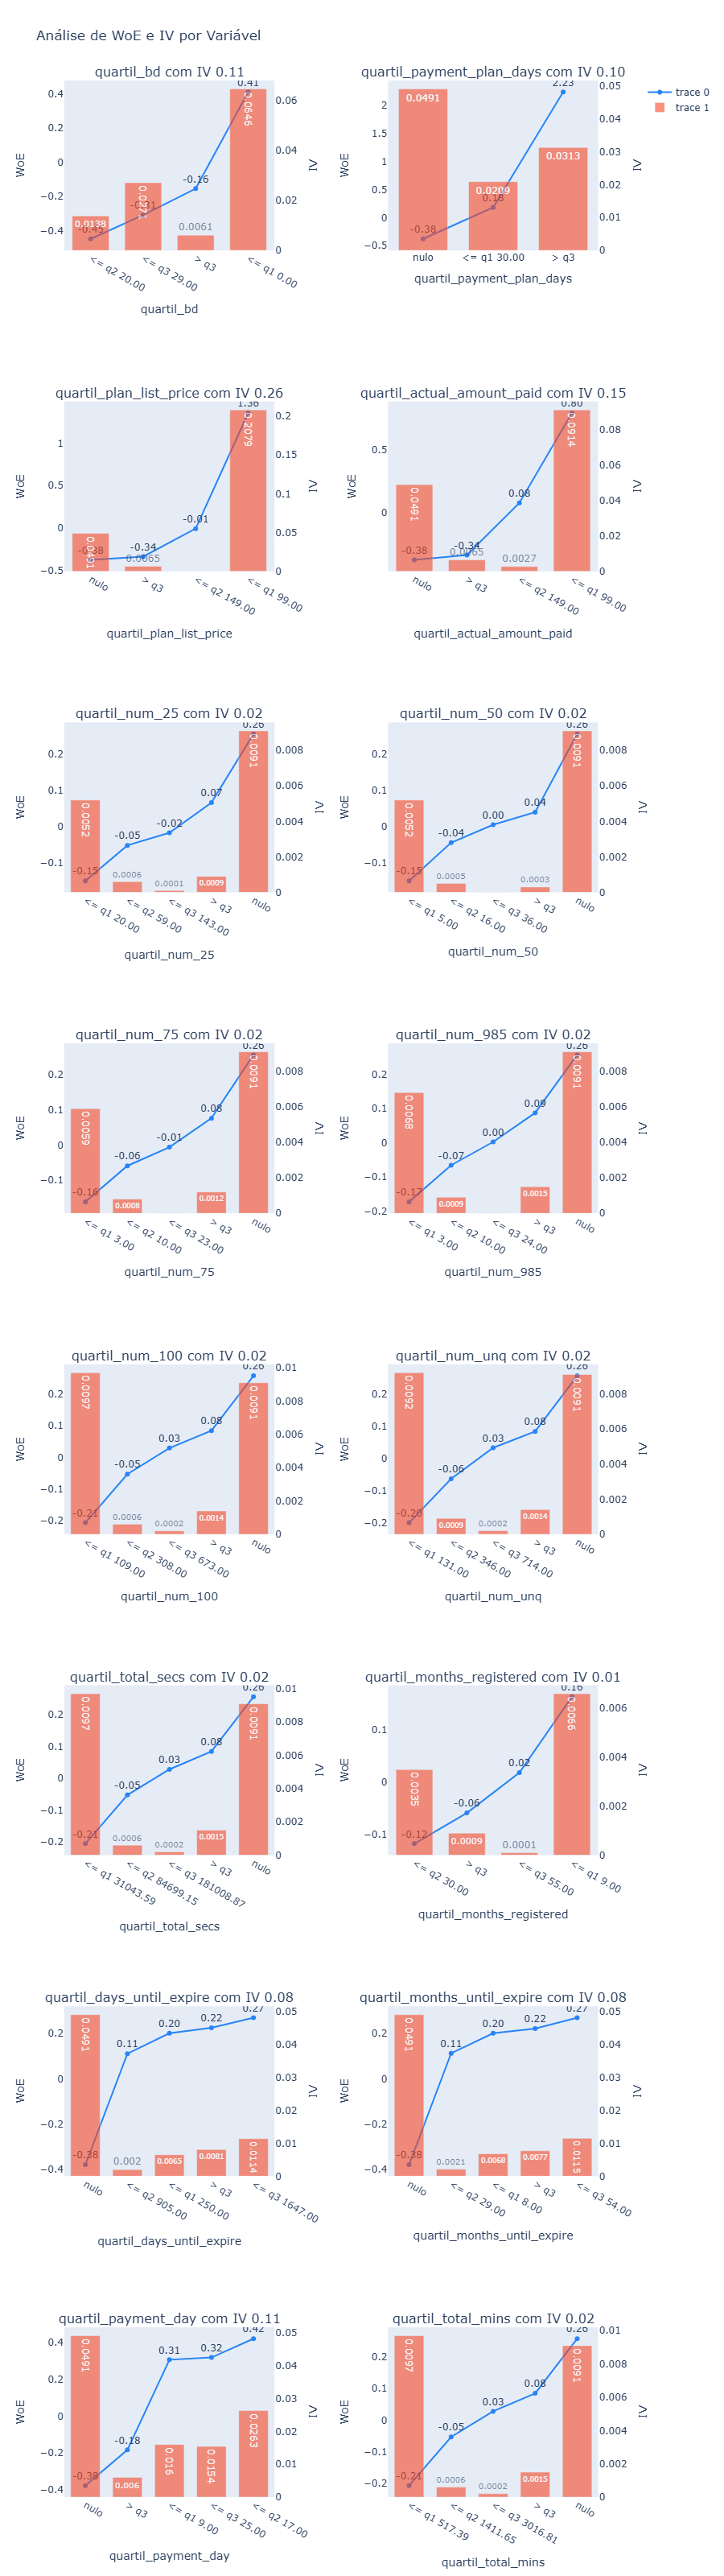

In [13]:
Image('/content/plot quartil var.png')

In [ ]:
# Tratamento nas colunas da transactions
df_treat_num = (df_enc_dt.withColumn("mbship_exp_dt_treated",F.when(F.col('membership_expire_date')<F.col('transaction_date'),
                                                                      F.date_add(F.col('transaction_date'), F.col('payment_plan_days')))
                                                                .otherwise(F.col('membership_expire_date'))
                                    )

                          .withColumn("bd_treated", F.when(F.col("bd")< 12, F.lit(0))
                                              .when(F.col("bd")> 54, F.lit(54))
                                              .otherwise(F.col('bd'))

                                      )

                          .withColumn("age_declared", F.when(F.col("bd_treated") == 0, F.lit(0))
                                                        .when(F.col('bd_treated') ==54, F.lit(54))
                                                        .otherwise(F.lit(1))
                                    )

                          .withColumn("total_secs_treated", F.when(F.col('total_secs')<0, F.lit(0))
                                  # .when(F.col('total_secs').isNull(), F.median(F.col('total_secs')))
                                  .when(F.col('total_secs')>929138.921, F.lit(929138.921))
                                  .otherwise(F.col('total_secs'))
                                  )

                        .withColumn('total_mins_treated', F.round(F.col('total_secs_treated')/60,2))

                        .withColumn('days_until_expire_treated', F.date_diff(F.col('mbship_exp_dt_treated'),
                                                                             F.col('registration_init_time')).cast('int')
                                    )

                        .withColumn('months_until_expire_treated', F.months_between(F.col('mbship_exp_dt_treated'),
                                                                                    F.col('registration_init_time')).cast('bigint')
                                   )

                          .drop('membership_expire_date', 'transaction_date',
                                'registration_init_time', 'bd', 'total_secs'
                                'days_until_expire', 'months_until_expire',
                                'total_mins', 'mbship_exp_dt_treated')
              )

In [ ]:
# Os valores acima do 99° percentil para bd e total_secs são factíveis, e portanto, serão utilizados como valores teto

quartils_99 = {}

for col in cols_num:
  quartils_99[col] = df_enc_dt.approxQuantile(col, [0.99], 0.0)
  print(col, df_enc_dt.select(col).filter(F.col(col) > quartils_99[col][0]).count(), quartils_99[col][0])

bd 13251 54.0
payment_plan_days 4101 195.0
plan_list_price 3941 894.0
actual_amount_paid 3941 894.0
num_25 12004 828.0
num_50 11944 190.0
num_75 12014 106.0
num_985 11826 127.0
num_100 12011 3752.0
num_unq 12009 2979.0
total_secs 12022 929118.9079999999
months_registered 12541 137.0
days_until_expire 9916 4175.0
months_until_expire 8998 137.0
payment_day 0 31.0
total_mins 12022 15485.32


In [ ]:
df_num_pd = df_treat_num.toPandas()

In [ ]:
# Definir as colunas para calcular a média
cols_to_avg = ['bd_treated', 'payment_plan_days', 'plan_list_price',
              'actual_amount_paid', 'num_25', 'num_50',
              'num_75', 'num_985', 'num_100',
              'num_unq', 'total_secs_treated',
               'months_registered',
              'days_until_expire_treated', 'months_until_expire_treated',
              'payment_day', 'total_mins_treated'] # Use as colunas tratadas ou originais conforme necessário

In [ ]:
df_media = gera_df_media(df_num_pd,cols_to_avg, num_splits=100)
gera_subplot_media(df_media, cols_to_avg, 3)

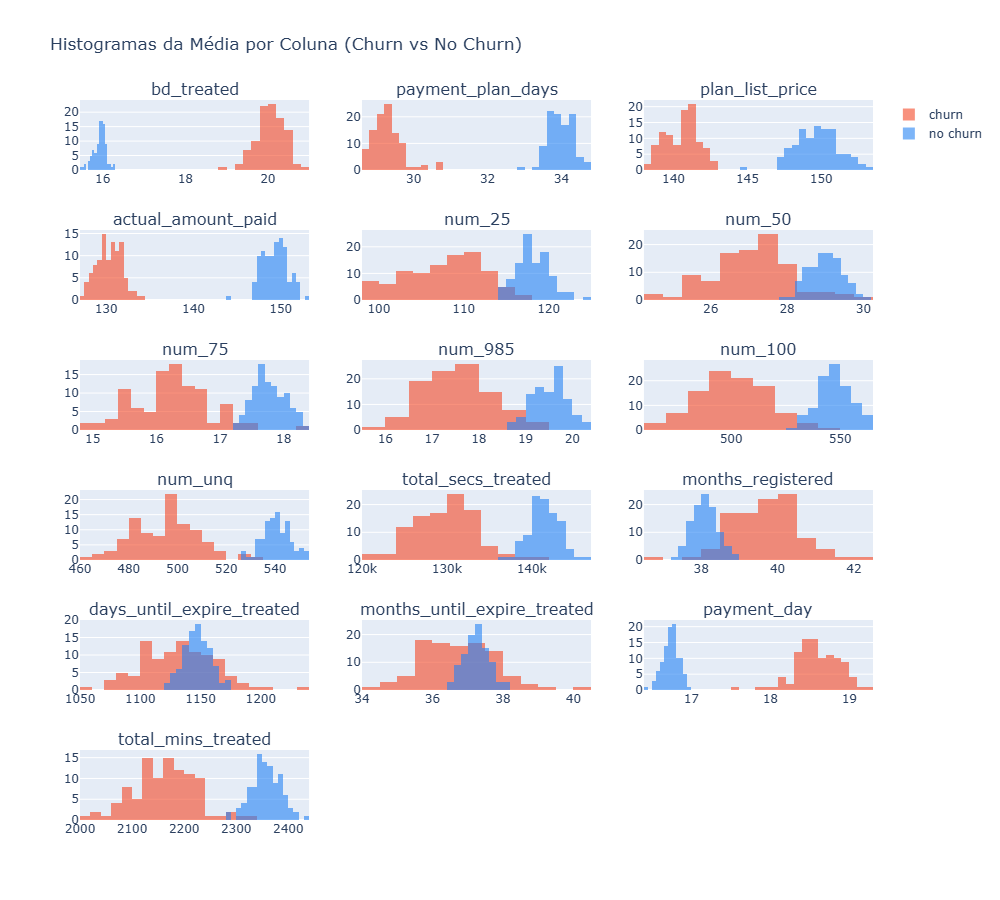

In [15]:
Image('/content/plot dist real churn x n churn.png')

In [ ]:
df_media = gera_df_media(df_num_pd,cols_to_avg, batch=1900)
gera_subplot_media(df_media, cols_to_avg, 3)

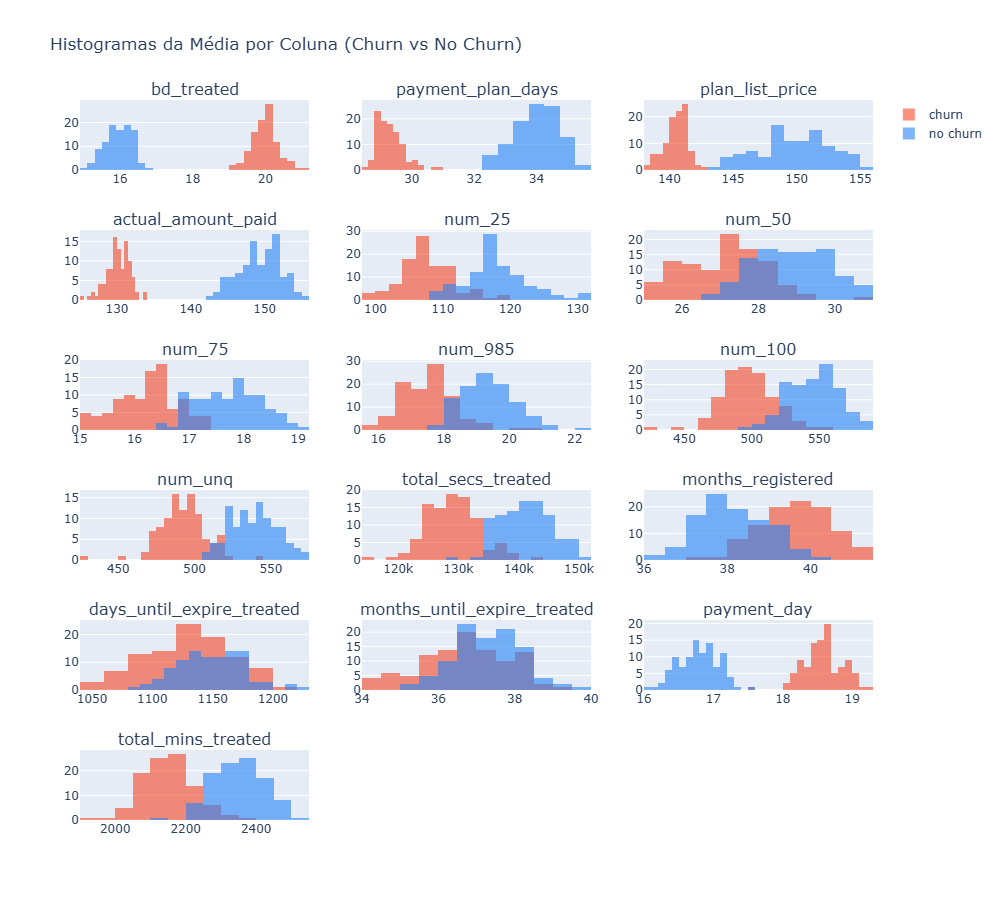

In [17]:
Image('/content/plot dist amostra churn x n churn.png')

In [ ]:
# Definir as colunas para calcular a média
cols_to_corr_orig = [col for col in df_num_pd.columns if col not in ['churn_origem', 'is_ativo', 'msno', 'safra', 'gender_treated']]


In [ ]:
# num 50 e num 75 91,74%  - dropar num 50
# num unq e num 100 92,96% - dropar num 100
# total min e total secs 100% - dropar total secs
# total min e num 100 - dropar num 100
# total min e num unq 100% - dropar num unq
# days until expire e months until expire - dropar days
# months registered e months until expire - dropar months until
# plan_list_price e actualamount_paid - dropar plan_list_price
# has_discount, pct_discount e discount - mantenho apenas a maior correlação com a target (pct_discount)
# age_declared e gender_declared - mantenho apenas a maior correlação com a target (gender_declared)
cors = correlation_plot(df_num_pd, cols_to_corr_orig)

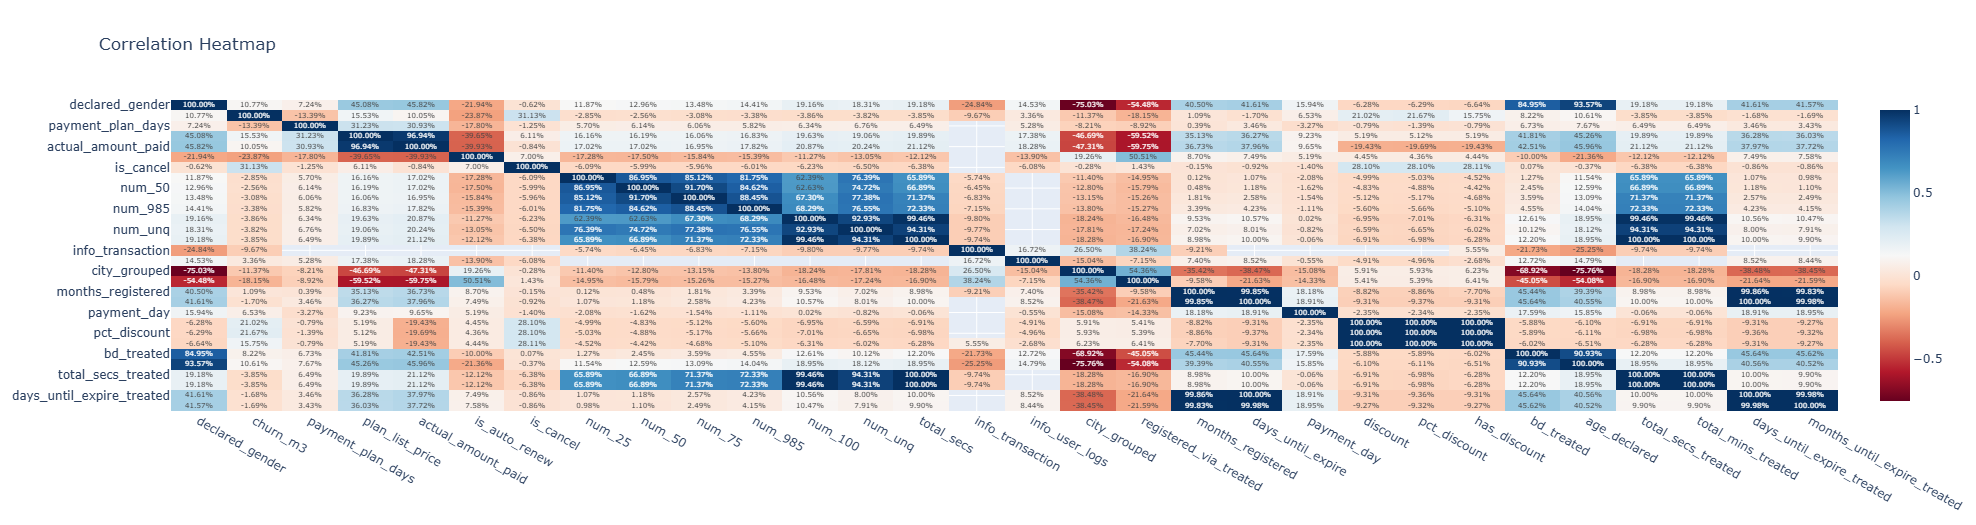

In [18]:
Image('/content/plot corr.png')

# 5. 💡 Feature Engineering

### Imports

trata malhas origem - Faz o pré processamento base de cada coluna com formato incorreto, além de tratamento das variáveis base para os modelos
prod malha - Gera as colunas que necessitam de variáveis de malhas diferentes
analisa malha - Gera as separações definidas para treino e teste, além de out-of-time filtrando as safras corretas.

In [113]:
def trata_transactions(df):
# Tratamento nas colunas da transactions

  wnd = W.partitionBy('msno').orderBy('safra')

  return (df.withColumn("payment_plan_days", F.col("payment_plan_days").cast('int'))
            .withColumn("plan_list_price", F.col("plan_list_price").cast('float'))
            .withColumn("actual_amount_paid", F.col("actual_amount_paid").cast('float'))
            .withColumn("is_auto_renew", F.col("is_auto_renew").cast('int'))
            .withColumn('is_auto_renew_m1', F.lag(F.col('is_auto_renew')).over(wnd))
            .withColumn('total_cancel_m3', F.sum(F.when(F.col('is_auto_renew').isin(0),1)).over(wnd.rowsBetween(-3,0)))
            .withColumn('total_cancel_m6', F.sum(F.when(F.col('is_auto_renew').isin(0),1)).over(wnd.rowsBetween(-6,0)))
            .withColumn("is_cancel", F.col("is_cancel").cast('int'))
            .withColumn('is_cancel_m1', F.lag(F.col('is_cancel')).over(wnd))
            .withColumn('total_cancel_m3', F.sum(F.col('is_cancel_m1')).over(wnd.rowsBetween(-2,0)))
            .withColumn('total_cancel_m6', F.sum(F.col('is_cancel_m1')).over(wnd.rowsBetween(-5,0)))
            .withColumn("safra", F.col("safra").cast('int'))
            .withColumn('pct_discount', F.when(F.col('plan_list_price')>F.col('actual_amount_paid'),
                                               F.lit(1) - F.round(F.col('actual_amount_paid')/F.col('plan_list_price'),4))
                                          .otherwise(F.lit(0))
                        )
            .withColumn("transaction_date_",date_transform('transaction_date'))
            .withColumn('payment_day', F.dayofmonth(F.col('transaction_date_')))
            .withColumn("membership_expire_date",date_transform('membership_expire_date'))
            .withColumn('pay_method_grouped', F.when(F.col('payment_method_id').isin(41), 1.1517)
                                                  .otherwise(F.lit(0.1141))
                                                  )
            # .withColumn("mbship_exp_dt_treated",F.when(F.col('membership_expire_date')<F.col('transaction_date'),
            #                                           F.date_add(F.col('transaction_date'), F.col('payment_plan_days')))
            #                                         .otherwise(F.col('membership_expire_date'))
            #               )

              )


def trata_members(df):
  ativo_m3 = F.lead('is_ativo',3).over(W.partitionBy('msno').orderBy('safra'))

  # Tratamento nas colunas da members

  return (df.withColumn("safra", F.col("safra").cast('int'))
                    .withColumn("registration_init_time_", date_transform('registration_init_time'))
                    .withColumn('months_registered', ((F.substring(F.col('safra').cast('string'),1,4).cast('int')
                                                        - F.year(F.col('registration_init_time_')))*12
                                                      + (F.substring(F.col('safra').cast('string'),5,2).cast('int')
                                                      - F.month(F.col('registration_init_time_')))).cast('bigint')
                                )

                    .withColumn("bd", F.col("bd").cast('int'))
                    .withColumn("bd_treated", F.when(F.col("bd")< 12, F.lit(0))
                                        .when(F.col("bd")> 54, F.lit(54))
                                        .otherwise(F.col('bd'))
                              )

                    # .withColumn("gender_", F.col("gender").cast('string'))
                    .withColumn('declared_gender', F.when(F.col('gender').isNull(), 0).otherwise(1))
                    .withColumn('gender_treated', F.when(F.col('gender').isin('male'), F.lit(1))
                                                            .when(F.col('gender').isin('female'), F.lit(-1))
                                                            .otherwise(F.lit(0))
                                )

                    .withColumn('city_grouped', F.when(F.col('city').isin(11,15), -0.4226)
                                                                  .when(F.col('city').isin(22, 18, 6, 17), -0.3279)
                                                                  .when(F.col('city').isin(10, 14, 8, 7, 21, 13), -0.2271)
                                                                  .when(F.col('city').isin(5, 4, 9, 12), -0.1808)
                                                                  .when(F.col('city').isin(20, 3, 16), -0.0719)
                                                                  .when(F.col('city').isin(19), 0.3652)
                                                                  .when(F.col('city').isin(1), 0.4923)
                                                                  .otherwise(0.000)
                                )

                    .withColumn('registered_via_treated', F.when(F.col('registered_via').isin(4), -0.5939)
                                                      .when(F.col('registered_via').isin(3), -0.4942)
                                                      .when(F.col('registered_via').isin(9), -0.334)
                                                      .when(F.col('registered_via').isin(7), 0.8601)
                                                      .otherwise(0.0000)
                                )

                    .withColumn('churn_m3', F.when((ativo_m3.isin(0)) & (F.col('is_ativo').isin(1)), 1)
                                              .otherwise(0)
                                )

                    .withColumn('churn_origem', F.when((F.col('is_ativo').isin(0)) & (ativo_m3.isin(0) | ativo_m3.isNull()), 1)
                                              .otherwise(0)
                                )
                    )

def trata_user_logs(df):
  # Tratamento nas colunas da user logs

  return (df.withColumn("total_secs_treated", F.when(F.col('total_secs')<0, F.lit(None))
                      .when(F.col('total_secs')>929138.921, F.lit(929138.921))
                      .otherwise(F.col('total_secs'))
                      )
              .withColumn('total_mins_treated', F.round(F.col('total_secs_treated')/60,2))
          )

def prod_malha(df):
  return (df
            .withColumn("safra", F.col("safra").cast('int'))

              # .withColumn('months_until_expire_treated', F.months_between(F.col('mbship_exp_dt_treated'),
              #                                               F.col('registration_init_time')).cast('bigint')
              #           )

              .withColumn('info_transaction', F.when(F.col('payment_plan_days').isNull(), 0).otherwise(1))

              .withColumn('info_user_logs', F.when(F.col('num_unq').isNull(), 0).otherwise(1))
            .withColumn("classWeight",F.lit(1))

              .drop('membership_expire_date',
                    'total_secs', 'total_secs_treated','payment_method_id',
                    'city', 'registered_via', 'bd',
                    'transaction_date', 'gender', 'registration_init_time',
                    'transaction_date_', 'registration_init_time_'
                    'plan_list_price', 'is_cancel')
    )


def analise_malha(transactions, members, user_logs, nm_parquet:str):
  transactions_p = trata_transactions(transactions)
  members_p = trata_members(members)
  user_logs_p = trata_user_logs(user_logs)

# Matendo apenas os meses com tempo suficiente para análise
  members_churn = members_p.filter((F.col('safra')<=201609) & F.col('churn_origem').isin(0))

  # Juntando todas as bases
  full_df = members_churn.join(transactions_p, on=['msno', 'safra'], how='left').join(user_logs_p, on=['msno', 'safra'], how='left')

  malha_final = prod_malha(full_df)

  # Quebrando a base treino (70%), teste (30%) de 201601-201606 e OOT 201607-201609
  # Considerando que temos apenas 9 meses para avaliação de churn, os 3 primeiros meses não podem ser inferidos como outliers, e portanto, serão tratados como sazonalidade
  # Quedas abruptas de ~5% por mês durante os 3 meses, basta um mês com a mesma variação para voltarmos a patamares próximos de churn
  full_df_train, full_df_test = malha_final.filter(F.col('safra').between(201601, 201606)).randomSplit([0.8, 0.2], seed=42)
  full_df_oot = malha_final.filter(F.col('safra').between(201607,201609))

  # # Load the data from the parquet file
  full_df_train = (full_df_train.withColumn("classWeight",
                              F.when(F.col("churn_m3") == 1, F.lit(3.7314))
                              .otherwise(F.lit(0.5773)))
                    )

  #Pela lei dos grandes números, uma parcela da amostra de treino deve ser suficiente para avaliar todas as situações de tratamento e feature engineering
  df_analysis = full_df_train.sample(fraction=0.3, seed=42)
  # df_analysis.write.mode("overwrite").parquet(nm_parquet + '.parquet')

  return full_df_train, full_df_test, full_df_oot, df_analysis



def analise_malha_sample(transactions, members, user_logs):
  transactions_p = trata_transactions(transactions)
  members_p = trata_members(members)
  user_logs_p = trata_user_logs(user_logs)

  members_churn = members_p.filter((F.col('safra')<=201609) & F.col('churn_origem').isin(0))

  full_df = members_churn.join(transactions_p, on=['msno', 'safra'], how='left').join(user_logs_p, on=['msno', 'safra'], how='left')

  malha_final = prod_malha(full_df).sample(fraction=0.3, seed=42)
  full_df_train, full_df_test = malha_final.filter(F.col('safra').between(201601, 201606)).randomSplit([0.8, 0.2], seed=42)
  full_df_oot = malha_final.filter(F.col('safra').between(201607,201609))

  full_df_train = (full_df_train.withColumn("classWeight",
                              F.when(F.col("churn_m3") == 1, F.lit(3.7314))
                              .otherwise(F.lit(0.5773)))
                    )

  return full_df_train, full_df_test, full_df_oot

In [16]:
# Dropei dos cálculos num_100, num_75, num_unq, num_total, num_under_50 porque eles têm alta correlação e baixa importância
cols_user_logs = ['num_25', 'num_75', 'num_985', 'total_mins_treated', 'num_under_75',]

# Dropei dos cálculos is_cancel porque ele atual é mais forte e plan_list_price porque ele tem alta correlação e baixa importância
cols_transactions_sum = ['payment_plan_days', 'payment_day', 'pct_discount', 'actual_amount_paid']
# Tratamento nas colunas da transactions
wnd = W.partitionBy('msno').orderBy('safra')


wnd_3m = wnd.rowsBetween(-2, 0)
wnd_6m = wnd.rowsBetween(-5, 0)

transactions_fe = (trata_transactions(transactions)

                    .withColumn("tenure_months_m3", (F.datediff(F.max("transaction_date_").over(wnd_3m), F.min("transaction_date_").over(wnd_3m))/30))
                    .withColumn("payment_method_changes_m3", F.approx_count_distinct("payment_method_id").over(wnd_3m))
                    .withColumn("plan_changes_m3", F.approx_count_distinct("payment_plan_days").over(wnd_3m))
                    .withColumn("tenure_months_m6", (F.datediff(F.max("transaction_date_").over(wnd_6m), F.min("transaction_date_").over(wnd_6m))/30))
                    .withColumn("payment_method_changes_m6", F.approx_count_distinct("payment_method_id").over(wnd_6m))
                    .withColumn("plan_changes_m6", F.approx_count_distinct("payment_plan_days").over(wnd_6m))

                    .select('*',
                            F.count(F.col('actual_amount_paid')).over(wnd_3m).alias('total_transaction_m3'),
                            F.count(F.col('actual_amount_paid')).over(wnd_6m).alias('total_transaction_m6'),
                            F.sum(F.col('actual_amount_paid')).over(wnd_3m).alias('total_paid_m3'),
                            F.sum(F.col('actual_amount_paid')).over(wnd_6m).alias('total_paid_m6'),
                          *[F.max(F.col(col)).over(wnd_3m).alias(col + '_max_m3') for col in cols_transactions_sum],
                          *[F.max(F.col(col)).over(wnd_6m).alias(col + '_max_m6') for col in cols_transactions_sum],
                          *[F.min(F.col(col)).over(wnd_3m).alias(col + '_min_m3') for col in cols_transactions_sum],
                          *[F.min(F.col(col)).over(wnd_6m).alias(col + '_min_m6') for col in cols_transactions_sum],
                          *[F.round(F.avg(F.col(col)).over(wnd_3m),2).alias(col + '_avg_m3') for col in cols_transactions_sum],
                          *[F.round(F.avg(F.col(col)).over(wnd_6m),2).alias(col + '_avg_m6') for col in cols_transactions_sum],
                          *[F.round((F.col(col) - F.lag(F.col(col), 3).over(wnd))/F.lag(F.col(col), 3).over(wnd), 2).alias(col + '_tend_m3') for col in cols_transactions_sum[3:]],
                          *[F.round((F.col(col) - F.lag(F.col(col), 6).over(wnd))/F.lag(F.col(col), 6).over(wnd), 2).alias(col + '_tend_m6') for col in cols_transactions_sum[3:]],
                            )
                   )

members_fe = (trata_members(members)
              )

user_logs_fe = (trata_user_logs(user_logs)
                      .withColumn('songs_played', F.col('num_25') + F.col('num_50') + F.col('num_75') + F.col('num_985') + F.col('num_100'))
                      .withColumn('num_under_75', F.col('num_25') + F.col('num_50') + F.col('num_75'))
                      .withColumn('num_under_50', F.col('num_25') + F.col('num_50'))
                      .withColumn('pct_under_75', F.round(F.col('num_under_75')/F.col('songs_played'),2))
                      .withColumn('pct_under_50', F.round(F.col('num_under_50')/F.col('songs_played'),2))

                      .withColumn("early_drop_rate", F.col("num_25") / F.when(F.col("songs_played")>0, F.col("songs_played")).otherwise(1))
                      .withColumn("avg_secs_per_song", F.col("total_secs_treated") / F.when(F.col("songs_played")>0, F.col("songs_played")).otherwise(1))
                      .withColumn('avg_songs_m3', F.avg(F.col('songs_played')).over(wnd_3m))
                      .withColumn("trend_play_count",
                                  (F.col("songs_played") - F.col("avg_songs_m3") / F.when(F.col("avg_songs_m3")>0, F.col("avg_songs_m3")).otherwise(1)))

                      .select('*',
                          *[F.sum(F.col(col)).over(wnd_3m).alias(col + '_sum_m3') for col in cols_user_logs],
                          *[F.sum(F.col(col)).over(wnd_6m).alias(col + '_sum_m6') for col in cols_user_logs],
                          *[F.max(F.col(col)).over(wnd_3m).alias(col + '_max_m3') for col in cols_user_logs],
                          *[F.max(F.col(col)).over(wnd_6m).alias(col + '_max_m6') for col in cols_user_logs],
                          *[F.min(F.col(col)).over(wnd_3m).alias(col + '_min_m3') for col in cols_user_logs],
                          *[F.min(F.col(col)).over(wnd_6m).alias(col + '_min_m6') for col in cols_user_logs],
                          *[F.round(F.avg(F.col(col)).over(wnd_3m),2).alias(col + '_avg_m3') for col in cols_user_logs],
                          *[F.round(F.avg(F.col(col)).over(wnd_6m),2).alias(col + '_avg_m6') for col in cols_user_logs],
                          *[F.round((F.col(col) - F.lag(F.col(col), 3).over(wnd))/F.lag(F.col(col), 3).over(wnd), 2).alias(col + '_tend_m3') for col in cols_user_logs],
                          *[F.round((F.col(col) - F.lag(F.col(col), 6).over(wnd))/F.lag(F.col(col), 6).over(wnd), 2).alias(col + '_tend_m6') for col in cols_user_logs],
                            )

                )

# full_df_train, full_df_test, full_df_oot, df_analysis_sp = analise_malha(transactions_fe, members_fe, user_logs_fe, 'df_analysis_fe')
full_df_train, full_df_test, full_df_oot = analise_malha_sample(transactions_fe, members_fe, user_logs_fe)

#6. Feature importance

In [114]:
def select_uncorrelated_features(df, feature_importances, threshold_corr=0.9):

    # 1. Ordena features pela importância (do maior pro menor)
    feature_importances = feature_importances.sort_values(by="Importance", ascending=False).reset_index(drop=True)
    features = feature_importances["Feature"].tolist()

    # 2. Seleciona apenas as features importantes do Spark DF

    # 4. Itera pelos pares de features altamente correlacionados
    to_remove = set()

    for i in range(len(features)):

        if features[i] in to_remove:
            continue

        for j in range(i+1, len(features)):
            if features[j] in to_remove:
                continue

            df_selected = df[[features[i], features[j]]]  # converte só as colunas de interesse
            # 3. Calcula correlação (Spearman é mais pesado, Pearson é mais rápido)
            corr = df_selected.corr(method="spearman").iloc[1,0]

            if abs(corr) > threshold_corr:
                # Remove a de menor importância
                to_remove.add(features[j])
                print(f'Mantida {features[i]}, {features[j]} removida correlação de {corr:.2f}')

    # 5. Mantém apenas as não removidas
    final_features = [f for f in features if f not in to_remove]

    return final_features, to_remove

In [ ]:
(full_df_train.filter(F.col('churn_origem').isin(0))
          .groupBy('is_cancel_m1')
          .agg(F.sum(F.col('is_ativo')).alias('ativos'),
               F.sum('churn_m3').alias('churns'))
          .withColumn('pct_churn', F.round(F.col('churns')/F.col('ativos'),2))
          ).show()

+------------+------+------+---------+
|is_cancel_m1|ativos|churns|pct_churn|
+------------+------+------+---------+
|        NULL|321558| 97117|      0.3|
|           1| 10482|  1591|     0.15|
|           0|917305| 91457|      0.1|
+------------+------+------+---------+



In [ ]:
(full_df_train.filter(F.col('churn_origem').isin(0))
          .groupBy('is_auto_renew_m1')
          .agg(F.sum(F.col('is_ativo')).alias('ativos'),
               F.sum('churn_m3').alias('churns'))
          .withColumn('pct_churn', F.round(F.col('churns')/F.col('ativos'),2))
          ).show()

+----------------+------+------+---------+
|is_auto_renew_m1|ativos|churns|pct_churn|
+----------------+------+------+---------+
|            NULL|321558| 97117|      0.3|
|               1|792908| 59992|     0.08|
|               0|134879| 33056|     0.25|
+----------------+------+------+---------+



In [ ]:
df_analysis_fe= full_df_train.drop('registration_init_time_').withColumn("random_", F.rand(seed=30))

In [ ]:
df_analysis_fe.write.mode("overwrite").parquet('/content/drive/MyDrive/df_analysis_fe.parquet')

In [106]:
df_analysis_fe = spark.read.parquet('/content/drive/MyDrive/df_analysis_fe.parquet')

In [ ]:
n_total = df_analysis_fe.count()
n_churn = df_analysis_fe.filter(F.col("churn_m3") == 1).count()
n_nonchurn = n_total - n_churn

# calcular pesos (versão "balanced")
w0 = n_total / (2 * n_nonchurn)
w1 = n_total / (2 * n_churn)

print(n_total, n_churn, n_nonchurn, w0, w1)

4247493 570495 3676998 0.5775761912299109 3.7226382352167855


In [ ]:
feature_cols = [col for col in df_analysis_fe.columns if col not in ['msno', 'safra', 'churn_m3', 'churn_origem', 'is_ativo', 'classWeight']]

imputer = Imputer(
    inputCols=feature_cols,
    # outputCols=[c + "_imputed" for c in feature_cols]
    outputCols=feature_cols
).setStrategy("median")  # ou "mean"

df_imputed = imputer.fit(df_analysis_fe).transform(df_analysis_fe)


# Assemble features into a vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
model_data = assembler.transform(df_imputed).select("features", 'classWeight', F.col("churn_m3").alias("label"))


In [ ]:
rf = RandomForestClassifier(labelCol="label",
                            featuresCol="features",
                            seed=42,
                            numTrees=100,           # mais árvores → importância estável
                            impurity="gini",           # mais rápido, sem perda prática
                            maxDepth=6,               # evita overfitting/ruído
                            minInstancesPerNode=100,        # splits mais gerais
                            featureSubsetStrategy="sqrt",
                            weightCol="classWeight" # corrige desbalanceamento manualmente
                            )

# Train the model
rf_model = rf.fit(model_data)

In [ ]:
# Get feature importances
feature_importances = rf_model.featureImportances

# Create a list of feature names
feature_names = [col for col in df_analysis_fe.columns if col not in ['msno', 'safra', 'churn_m3', 'churn_origem', 'is_ativo', 'classWeight']]

# Create a pandas DataFrame to store feature names and their importance scores
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances.toArray()
})

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importance
print("Feature Importance:")
vl = importance_df[importance_df['Feature']=='random_']['Importance'].to_list()[0]
total_features = len(importance_df[importance_df['Importance']>vl])
print(total_features, len(importance_df))

Feature Importance:
119 122


In [ ]:
pd.set_option("display.max_rows", None)
print(importance_df[importance_df['Importance']>vl].head(total_features))

                        Feature    Importance
17             tenure_months_m3  8.134104e-02
30    actual_amount_paid_max_m3  7.068586e-02
5        registered_via_treated  6.815863e-02
8            actual_amount_paid  4.980377e-02
38    actual_amount_paid_min_m3  4.688377e-02
20             tenure_months_m6  4.670094e-02
7               plan_list_price  4.302407e-02
40           payment_day_min_m6  4.288964e-02
36           payment_day_min_m3  3.766186e-02
46    actual_amount_paid_avg_m3  3.416822e-02
44           payment_day_avg_m3  3.338861e-02
9                 is_auto_renew  3.134607e-02
25                total_paid_m3  2.739468e-02
28           payment_day_max_m3  2.715526e-02
50    actual_amount_paid_avg_m6  2.561780e-02
26                total_paid_m6  2.553247e-02
48           payment_day_avg_m6  2.521472e-02
42    actual_amount_paid_min_m6  2.387433e-02
32           payment_day_max_m6  2.261796e-02
119            info_transaction  2.204031e-02
15                  payment_day  2

In [ ]:
import plotly.express as px

# Create a bar chart
fig = px.bar(importance_df[importance_df['Importance']>vl],
             x='Importance',
             y='Feature',
             orientation='h',  # Set orientation to horizontal for horizontal bars
             title='Feature Importance from Random Forest Model')

# Reverse the order of features to have the most important at the top
fig.update_layout(yaxis={'categoryorder':'total ascending'},
                  width=900,  # Largura ligeiramente menor que 794px para margens
                  height=450, # Altura ligeiramente menor que 1123px para margens
                  )


# Display the plot
fig.show()

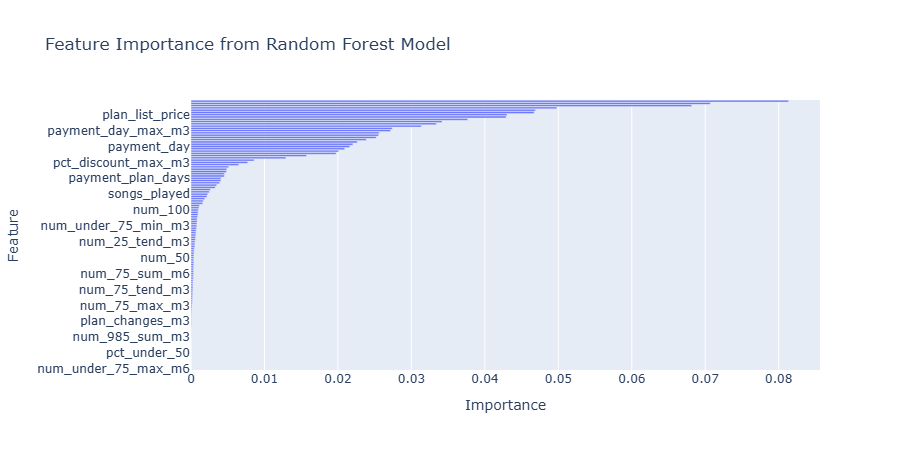

In [19]:
Image('/content/fi total.png')

In [ ]:
importance_df.to_parquet('/content/drive/MyDrive/feature_importance.parquet')

## Selecionando as variáveis finais

In [108]:
importance_df = pd.read_parquet('/content/drive/MyDrive/feature_importance.parquet')

vl = importance_df[importance_df['Feature']=='random_']['Importance'].to_list()[0]

In [109]:
cols = importance_df[importance_df['Importance']>vl]['Feature'].to_list()

df_analysis_pd = pd.read_parquet('/content/drive/MyDrive/df_analysis_fe.parquet', columns=cols)

In [ ]:
final_features, to_remove = select_uncorrelated_features(df_analysis_pd, importance_df[importance_df['Importance']>vl], 0.9)

Mantida actual_amount_paid_max_m3, actual_amount_paid removida correlação de 0.96
Mantida actual_amount_paid_max_m3, actual_amount_paid_min_m3 removida correlação de 0.91
Mantida actual_amount_paid_max_m3, plan_list_price removida correlação de 0.94
Mantida actual_amount_paid_max_m3, actual_amount_paid_avg_m3 removida correlação de 0.96
Mantida actual_amount_paid_max_m3, actual_amount_paid_avg_m6 removida correlação de 0.94
Mantida actual_amount_paid_max_m3, actual_amount_paid_max_m6 removida correlação de 0.96
Mantida registered_via_treated, pay_method_grouped removida correlação de 0.93
Mantida payment_day_min_m6, payment_day_min_m3 removida correlação de 0.96
Mantida payment_day_avg_m3, payment_day_max_m3 removida correlação de 0.92
Mantida payment_day_avg_m3, payment_day_avg_m6 removida correlação de 0.97
Mantida payment_day_avg_m3, payment_day removida correlação de 0.92
Mantida is_auto_renew, is_auto_renew_m1 removida correlação de 0.95
Mantida pct_discount_avg_m6, pct_discount_m

In [ ]:
final_features

['tenure_months_m3',
 'actual_amount_paid_max_m3',
 'registered_via_treated',
 'tenure_months_m6',
 'payment_day_min_m6',
 'payment_day_avg_m3',
 'is_auto_renew',
 'total_paid_m3',
 'total_paid_m6',
 'actual_amount_paid_min_m6',
 'payment_day_max_m6',
 'info_transaction',
 'total_transaction_m6',
 'total_transaction_m3',
 'pct_discount_avg_m6',
 'city_grouped',
 'pct_discount_max_m3',
 'pct_discount',
 'payment_plan_days_min_m3',
 'info_user_logs',
 'payment_plan_days_avg_m6',
 'payment_plan_days',
 'payment_plan_days_avg_m3',
 'months_registered',
 'total_mins_treated',
 'payment_plan_days_max_m6',
 'payment_plan_days_min_m6',
 'total_mins_treated_min_m3',
 'plan_changes_m6',
 'total_mins_treated_min_m6',
 'total_mins_treated_sum_m6',
 'num_985_tend_m6',
 'payment_method_changes_m6',
 'bd_treated',
 'num_under_75_min_m3',
 'total_mins_treated_tend_m6',
 'num_under_50',
 'declared_gender',
 'payment_method_changes_m3',
 'num_under_75_sum_m6',
 'num_25_tend_m3',
 'num_25_avg_m3',
 'num_

In [111]:
df_analysis_pd = pd.read_parquet('/content/drive/MyDrive/df_analysis_fe.parquet', columns=final_features)

In [ ]:
import plotly.express as px

# Create a bar chart
fig = px.bar(importance_df[importance_df['Feature'].isin(final_features)],
             x='Importance',
             y='Feature',
             orientation='h',  # Set orientation to horizontal for horizontal bars
             title='Feature Importance from Random Forest Model')

# Reverse the order of features to have the most important at the top
fig.update_layout(yaxis={'categoryorder':'total ascending'},
                  width=900,  # Largura ligeiramente menor que 794px para margens
                  height=450, # Altura ligeiramente menor que 1123px para margens
                  )


# Display the plot

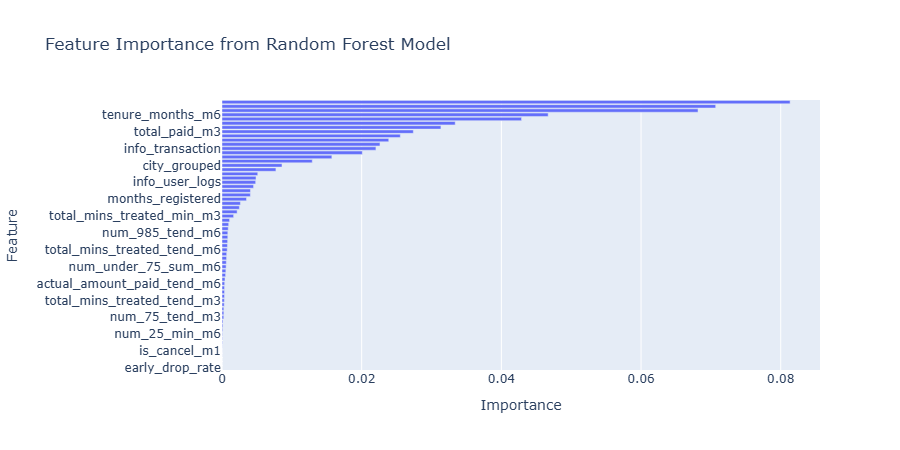

In [21]:
Image('/content/fi final.png')

#7.  Modelo V0 - Comparação


### Salvando variáveis finais

In [110]:
final_features = [
    'tenure_months_m3',
 'actual_amount_paid_max_m3',
 'registered_via_treated',
 'tenure_months_m6',
 'payment_day_min_m6',
 'payment_day_avg_m3',
 'is_auto_renew',
 'total_paid_m3',
 'total_paid_m6',
 'actual_amount_paid_min_m6',
 'payment_day_max_m6',
 'info_transaction',
 'total_transaction_m6',
 'total_transaction_m3',
 'pct_discount_avg_m6',
 'city_grouped',
 'pct_discount_max_m3',
 'pct_discount',
 'payment_plan_days_min_m3',
 'info_user_logs',
 'payment_plan_days_avg_m6',
 'payment_plan_days',
 'payment_plan_days_avg_m3',
 'months_registered',
 'total_mins_treated',
 'payment_plan_days_max_m6',
 'payment_plan_days_min_m6',
 'total_mins_treated_min_m3',
 'plan_changes_m6',
 'total_mins_treated_min_m6',
 'total_mins_treated_sum_m6',
 'num_985_tend_m6',
 'payment_method_changes_m6',
 'bd_treated',
 'num_under_75_min_m3',
 'total_mins_treated_tend_m6',
 'num_under_50',
 'declared_gender',
 'payment_method_changes_m3',
 'num_under_75_sum_m6',
 'num_25_tend_m3',
 'num_25_avg_m3',
 'num_75_tend_m6',
 'actual_amount_paid_tend_m6',
 'num_25_tend_m6',
 'num_985_min_m3',
 'actual_amount_paid_tend_m3',
 'total_mins_treated_tend_m3',
 'num_75',
 'num_985_max_m6',
 'num_985_tend_m3',
 'num_75_tend_m3',
 'num_75_max_m3',
 'num_75_min_m6',
 'total_cancel_m3',
 'num_25_min_m6',
 'num_985',
 'plan_changes_m3',
 'total_cancel_m6',
 'is_cancel_m1',
 'gender_treated',
 'avg_secs_per_song',
 'num_985_min_m6',
 'early_drop_rate'
]

len(final_features)

64

### Salva bases

In [18]:
full_df_train.select('msno', 'safra', 'churn_origem', 'is_ativo', 'churn_m3',*final_features, 'classWeight').write.parquet('/content/drive/MyDrive/full_df_train.parquet', mode='overwrite')
size_ = os.path.getsize('/content/drive/MyDrive/full_df_train.parquet')
print(f'{size_/1024:.2} Mb')

full_df_test.select('msno', 'safra', 'churn_origem', 'is_ativo', 'churn_m3',*final_features, 'classWeight').write.parquet('/content/drive/MyDrive/full_df_test.parquet', mode='overwrite')
size_ = os.path.getsize('/content/drive/MyDrive/full_df_test.parquet')
print(f'{size_/1024:.2} Mb')

full_df_oot.select('msno', 'safra', 'churn_origem', 'is_ativo', 'churn_m3',*final_features, 'classWeight').write.parquet('/content/drive/MyDrive/full_df_oot.parquet', mode='overwrite')
size_ = os.path.getsize('/content/drive/MyDrive/full_df_oot.parquet')
print(f'{size_/1024:.2} Mb')

4.0 Mb
4.0 Mb
4.0 Mb


### Modelagem

In [7]:
full_df_train = spark.read.parquet('/content/drive/MyDrive/full_df_train.parquet')
full_df_train.cache()
full_df_test = spark.read.parquet('/content/drive/MyDrive/full_df_test.parquet')
full_df_test.cache()
full_df_oot = spark.read.parquet('/content/drive/MyDrive/full_df_oot.parquet')
full_df_oot.cache()

DataFrame[msno: string, safra: int, churn_origem: int, is_ativo: int, churn_m3: int, tenure_months_m3: double, actual_amount_paid_max_m3: float, registered_via_treated: double, tenure_months_m6: double, payment_day_min_m6: int, payment_day_avg_m3: double, is_auto_renew: int, total_paid_m3: double, total_paid_m6: double, actual_amount_paid_min_m6: float, payment_day_max_m6: int, info_transaction: int, total_transaction_m6: bigint, total_transaction_m3: bigint, pct_discount_avg_m6: double, city_grouped: double, pct_discount_max_m3: double, pct_discount: double, payment_plan_days_min_m3: int, info_user_logs: int, payment_plan_days_avg_m6: double, payment_plan_days: int, payment_plan_days_avg_m3: double, months_registered: bigint, total_mins_treated: double, payment_plan_days_max_m6: int, payment_plan_days_min_m6: int, total_mins_treated_min_m3: double, plan_changes_m6: bigint, total_mins_treated_min_m6: double, total_mins_treated_sum_m6: double, num_985_tend_m6: double, payment_method_cha

In [20]:
avalia_nulos(full_df_train, full_df_train.count())

msno tem 0.00% nulos
safra tem 0.00% nulos
churn_origem tem 0.00% nulos
is_ativo tem 0.00% nulos
churn_m3 tem 0.00% nulos
tenure_months_m3 tem 30.06% nulos
actual_amount_paid_max_m3 tem 30.06% nulos
registered_via_treated tem 0.00% nulos
tenure_months_m6 tem 30.06% nulos
payment_day_min_m6 tem 30.06% nulos
payment_day_avg_m3 tem 30.06% nulos
is_auto_renew tem 30.06% nulos
total_paid_m3 tem 30.06% nulos
total_paid_m6 tem 30.06% nulos
actual_amount_paid_min_m6 tem 30.06% nulos
payment_day_max_m6 tem 30.06% nulos
info_transaction tem 0.00% nulos
total_transaction_m6 tem 30.06% nulos
total_transaction_m3 tem 30.06% nulos
pct_discount_avg_m6 tem 30.06% nulos
city_grouped tem 0.00% nulos
pct_discount_max_m3 tem 30.06% nulos
pct_discount tem 30.06% nulos
payment_plan_days_min_m3 tem 30.06% nulos
info_user_logs tem 0.00% nulos
payment_plan_days_avg_m6 tem 30.06% nulos
payment_plan_days tem 30.06% nulos
payment_plan_days_avg_m3 tem 30.06% nulos
months_registered tem 0.00% nulos
total_mins_treat

In [9]:
def ks_metric(df_pred, n_bins=10):

    df_pred = df_pred.withColumn("proba1", vector_to_array("probability").getItem(1))

    # 2️⃣ Criar decil ou bin baseado em ntile
    w = W.orderBy(F.col("proba1").desc())
    df_pred = df_pred.withColumn("decile", F.ntile(n_bins).over(w))

    # 3️⃣ Agregar por decil
    agg = df_pred.groupBy("decile").agg(
        F.sum("churn_m3").alias("bad"),
        F.sum(1 - F.col("churn_m3")).alias("good")
    ).orderBy("decile", ascending=False)

    # 4️⃣ Total de bons e maus
    total_bad  = df_pred.filter(F.col("churn_m3")==1).count()
    total_good = df_pred.filter(F.col("churn_m3")==0).count()

    # 5️⃣ Calcular cumulativos
    w2 = W.orderBy("decile").rowsBetween(W.unboundedPreceding, 0)
    agg = agg.withColumn("cum_bad", F.sum("bad").over(w2)/total_bad)
    agg = agg.withColumn("cum_good", F.sum("good").over(w2)/total_good)

    # 6️⃣ KS por decil
    agg = agg.withColumn("ks", F.abs(F.col("cum_bad") - F.col("cum_good")))

    # 7️⃣ Retornar KS máximo
    ks_value = agg.agg(F.max("ks")).first()[0]
    return ks_value


In [122]:
def pipe(df_spark, model):
  feature_cols = [col for col in df_spark.columns if col not in ['msno', 'safra', 'churn_m3', 'churn_origem', 'is_ativo', 'classWeight', 'is_validation'] and col in final_features]

  imputer = Imputer(
      inputCols=feature_cols,
      outputCols=feature_cols
  ).setStrategy("median")  # ou "mean"

  # Define individual stages
  assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

  # Create the pipeline
  return Pipeline(stages=[imputer, assembler, model])


def pipe_xgb(df_spark, model):
  feature_cols = [col for col in df_spark.columns if col not in ['msno', 'safra', 'churn_m3', 'churn_origem', 'is_ativo', 'classWeight', 'is_validation'] and col in final_features]

  imputer = Imputer(
    inputCols=feature_cols,
    outputCols=feature_cols,
    strategy="median" #
                  ).setMissingValue(-99) # Define o valor de substituição


  # Define individual stages
  assembler = VectorAssembler(inputCols=feature_cols, outputCol="features", handleInvalid="keep")

  # Create the pipeline
  return Pipeline(stages=[assembler, model])

def model_training(model, pipe, train, test, oot=None):

  model_name = type(model).__name__

  preproc_model = pipe(train, model).fit(train)

  train_dt = preproc_model.transform(train)
  test_dt = preproc_model.transform(test)

  evaluator = BinaryClassificationEvaluator(
    labelCol="churn_m3",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
    )

  ks_train = ks_metric(train_dt)
  ks_test = ks_metric(test_dt)


  auc_train_dt = evaluator.evaluate(train_dt)
  auc_test_dt = evaluator.evaluate(test_dt)

  print(f'============ {model_name} ============')
  print(f"AUC train : {auc_train_dt:.4f}")
  print(f"AUC test : {auc_test_dt:.4f}")
  print('-'*60)
  print(f"KS train : {ks_train:.4f}")
  print(f"KS test : {ks_test:.4f}")
  print('='*60)

  if oot:
    oot_dt = preproc_model.transform(oot)
    auc_oot_dt = evaluator.evaluate(oot_dt)
    ks_oot = ks_metric(oot_dt)

    print(f"AUC OOT : {auc_oot_dt:.4f}")
    print(f"KS OOT : {ks_oot:.4f}")
    print('='*60)

    return test_dt, oot_dt, preproc_model

  return test_dt, preproc_model


In [76]:

'''
 Por questões de tempo e por ter utilizado random forest para construir o feature importance, achei prudente em viés de robustez, mas com maior eficiência e interpretabilidade
usar uma Árvore de Decisão como modelo base.
  Dado também que leva em conta os mesmos tratamentos que Random Forest, diferente do Regressão logística que ainda demandaria um escalonamento.
'''

# Decision Tree
dt = DecisionTreeClassifier(
    labelCol="churn_m3",
    featuresCol="features",
    seed=42,
    impurity="gini",              # mesmo critério da RF
    maxDepth=14,                  # controla overfitting
    minInstancesPerNode=1000,       # deixa os splits mais gerais
    weightCol="classWeight"       # corrige desbalanceamento
)


# Random Forest
rf = RandomForestClassifier(
                            labelCol="churn_m3",
                            featuresCol="features",
                            seed=42,
                            numTrees=100,           # mais árvores → importância estável
                            impurity="gini",           # mais rápido, sem perda prática
                            maxDepth=6,               # evita overfitting/ruído
                            minInstancesPerNode=1000,        # splits mais gerais
                            featureSubsetStrategy="sqrt",
                            weightCol="classWeight" # corrige desbalanceamento manualmente
)

xgb = SparkXGBClassifier(
    label_col="churn_m3",          # target
    features_col="features",       # vetor de features
    weight_col="classWeight",      # corrige desbalanceamento
    seed=42,

    # Complexidade do modelo
    num_round=100,                 # número de boosting rounds (similar a numTrees)
    max_depth=4,                  # profundidade máxima das árvores
    min_child_weight=1000,           # tamanho mínimo de amostra em cada folha (similar ao minInstancesPerNode)

    # Regularização / controle de overfitting
    eta=0.03,                       # learning rate → shrinkage
    subsample=0.8,                 # amostragem de linhas
    colsample_bytree=0.8,          # amostragem de colunas
    reg_gamma=0.1,

    eval_metric="logloss",              # métrica de avaliação (pode trocar para "logloss")
    missing=-99,
    num_workers=4
)

In [28]:
# A lei dos grandes números e os teste realizados, não necessário treinar com todos os dados
# Os resultados apesar de próximos, foram melhores no xgboost, e portanto, seguiremos para otimização com ele
preds_dt, trained_model_dt = model_training(dt, pipe, full_df_train, full_df_test)

============ DecisionTreeClassifier ============
AUC train : 0.6938
AUC test : 0.6912
------------------------------------------------------------
KS train : 0.5446
KS test : 0.5406


In [29]:
preds_rf, trained_model_rf = model_training(rf, pipe, full_df_train, full_df_test)

============ RandomForestClassifier ============
AUC train : 0.8279
AUC test : 0.8258
------------------------------------------------------------
KS train : 0.4955
KS test : 0.4948


In [77]:
preds_xgb, trained_model_xgb = model_training(xgb, pipe_xgb, full_df_train, full_df_test)

INFO:XGBoost-PySpark:Running xgboost-3.0.5 on 4 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8, 'device': 'cpu', 'eval_metric': 'logloss', 'max_depth': 4, 'min_child_weight': 1000, 'subsample': 0.8, 'seed': 42, 'num_round': 100, 'eta': 0.03, 'reg_gamma': 0.1, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': -99.0}
INFO:XGBoost-PySpark:Finished xgboost training!


============ SparkXGBClassifier ============
AUC train : 0.8412
AUC test : 0.8394
------------------------------------------------------------
KS train : 0.5235
KS test : 0.5225


# 8. Validando modelo V1

In [78]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

xgb_validation = SparkXGBClassifier(
    label_col="churn_m3",          # target
    features_col="features",       # vetor de features
    weight_col="classWeight",      # corrige desbalanceamento
    seed=42,

    min_child_weight=1000,           # tamanho mínimo de amostra em cada folha (similar ao minInstancesPerNode)
    # eta=0.05,                       # learning rate → shrinkage
    subsample=0.8,                 # amostragem de linhas
    num_round=100,                 # número de boosting rounds (similar a numTrees)

    reg_lambda=1,
    reg_alpha=1,
    eval_metric="logloss",              # métrica de avaliação (pode trocar para "logloss")

    num_workers=4,
    missing=-99
)

pipe_ = pipe_xgb(full_df_train, xgb_validation)

# Create ParamGrid for Cross Validation (using a single parameter for simplicity)
# You can add more hyperparameters to tune here
paramGrid_xgb_validation = (ParamGridBuilder()
            .addGrid(xgb_validation.max_depth, [4, 6])
            .addGrid(xgb_validation.learning_rate, [0.03, 0.05])
            .addGrid(xgb_validation.colsample_bytree, [0.6, 0.8])
            .addGrid(xgb_validation.gamma, [0.1, 1])

             .build())

evaluator = BinaryClassificationEvaluator(
  labelCol="churn_m3",
  rawPredictionCol="rawPrediction",
  metricName="areaUnderROC"
  )

# Create CrossValidator
cv_xgb_validation = CrossValidator(estimator=pipe_,
                        estimatorParamMaps=paramGrid_xgb_validation,
                        evaluator=evaluator,
                        numFolds=3, # You can adjust the number of folds
                        parallelism=4,
                        seed=42)

# ==========================================================
# 7. Treino
# ==========================================================
cvModel = cv_xgb_validation.fit(full_df_train)

# ==========================================================
# 8. Avaliação
# ==========================================================
pred_train = cvModel.transform(full_df_train)
pred_test  = cvModel.transform(full_df_test)
pred_oot   = cvModel.transform(full_df_oot)

auc_train = evaluator.evaluate(pred_train)
auc_test  = evaluator.evaluate(pred_test)
auc_oot   = evaluator.evaluate(pred_oot)

ks_train = ks_metric(pred_train)
ks_test  = ks_metric(pred_test)
ks_oot   = ks_metric(pred_oot)


INFO:XGBoost-PySpark:Running xgboost-3.0.5 on 4 workers with
	booster params: {'colsample_bytree': 0.6, 'device': 'cpu', 'eval_metric': 'logloss', 'gamma': 1, 'learning_rate': 0.03, 'max_depth': 4, 'min_child_weight': 1000, 'objective': 'binary:logistic', 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.8, 'seed': 42, 'num_round': 100, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': -99.0}
INFO:XGBoost-PySpark:Running xgboost-3.0.5 on 4 workers with
	booster params: {'colsample_bytree': 0.8, 'device': 'cpu', 'eval_metric': 'logloss', 'gamma': 0.1, 'learning_rate': 0.03, 'max_depth': 4, 'min_child_weight': 1000, 'objective': 'binary:logistic', 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.8, 'seed': 42, 'num_round': 100, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': -99.0}
INFO:XGBoost-PySpark:Running xgboost-3.0.5 on 4 

In [79]:

print("========== XG Boost CV Results ==========")
print(f"AUC Train: {auc_train:.4f}")
print(f"AUC Test : {auc_test:.4f}")
print(f"AUC OOT  : {auc_oot:.4f}")
print("------------------------------------------")
print(f"KS Train : {ks_train:.4f}")
print(f"KS Test  : {ks_test:.4f}")
print(f"KS OOT   : {ks_oot:.4f}")
print("==========================================")
print()



========== XG Boost CV Results ==========
AUC Train: 0.8539
AUC Test : 0.8517
AUC OOT  : 0.8292
------------------------------------------
KS Train : 0.5417
KS Test  : 0.5406
KS OOT   : 0.5523



In [80]:
final_pipeline_model = cvModel.bestModel

model_stage_index = len(final_pipeline_model.stages) - 1
best_xgboost_estimator = final_pipeline_model.stages[model_stage_index]

param_map = best_xgboost_estimator.extractParamMap()

print(f"--- Parâmetros Escolhidos para o Modelo XGBoost Final ---")
print(f"Classe do Modelo: {best_xgboost_estimator.__class__.__name__}\n")

for param, value in param_map.items():
    tuned_params = ['max_depth', 'learning_rate', 'colsample_bytree', 'gamma']

    if param.name in tuned_params:

        print(f"Parâmetro '{param.name}': {value}")

--- Parâmetros Escolhidos para o Modelo XGBoost Final ---
Classe do Modelo: SparkXGBClassifierModel

Parâmetro 'colsample_bytree': 0.8
Parâmetro 'gamma': 1
Parâmetro 'learning_rate': 0.05
Parâmetro 'max_depth': 6


In [82]:
# ----------------------------------------------------------------------
# 1. Extrair e Estruturar os Resultados do CrossValidator
# ----------------------------------------------------------------------

# O CrossValidator armazena as métricas médias para CADA combinação de parâmetro.
avg_metrics = cvModel.avgMetrics

# O ParamGrid armazena todas as combinações testadas.
param_maps = cvModel.getEstimatorParamMaps()

# Crie uma lista para armazenar os resultados
results = []
for i, metric in enumerate(avg_metrics):
    param_map = param_maps[i]


    # Adiciona a linha de resultados
    results.append({
        'max_depth': param_map.get(xgb_validation.max_depth),
        'auc_avg': metric, # A métrica média do CV (validação)
        'learning_rate': param_map.get(xgb_validation.learning_rate), # Usado para colorir/agrupar
        'colsample_bytree': param_map.get(xgb_validation.colsample_bytree), # Usado para colorir/agrupar
        'gamma': param_map.get(xgb_validation.gamma) # Usado para colorir/agrupar
    })

# Converte para DataFrame Pandas
results_df = pd.DataFrame(results)

# Agrupa e calcula a média das métricas para cada profundidade (se houver repetição)
# Isso é importante se você testou muitas combinações.
plot_df = results_df.groupby(['max_depth', 'learning_rate']).agg(
    auc_medio=('auc_avg', 'mean')
).reset_index()

# ----------------------------------------------------------------------
# 2. Plotar a Curva de Desempenho (Métrica vs. Parâmetro)
# ----------------------------------------------------------------------

fig_curva = px.line(
    plot_df,
    x='max_depth',              # Eixo X: Parâmetro de complexidade
    y='auc_medio',              # Eixo Y: Métrica de validação (AUC média)
    color='learning_rate',      # Agrupa as linhas por outro parâmetro (opcional)
    markers=True,
    title='Curva de Validação Cruzada: AUC vs. Profundidade Máxima (max_depth)',
    # labels={
    #     'max_depth': 'Profundidade Máxima da Árvore (max_depth)',
    #     'auc_medio': 'AUC Média de Validação Cruzada',
    #     'learning_rate': 'Taxa de Aprendizado (learning_rate)'
    # }
)

fig_curva.update_layout(
    xaxis = {'tickmode': 'linear'}, # Garante que max_depth seja tratado como numérico
    hovermode="x unified",
    width=800,
    height=600
)

fig_curva.show()

plot_df = results_df.groupby(['colsample_bytree', 'gamma']).agg(
    auc_medio=('auc_avg', 'mean')
).reset_index()

# ----------------------------------------------------------------------
# 2. Plotar a Curva de Desempenho (Métrica vs. Parâmetro)
# ----------------------------------------------------------------------

fig_curva = px.line(
    plot_df,
    x='colsample_bytree',              # Eixo X: Parâmetro de complexidade
    y='auc_medio',              # Eixo Y: Métrica de validação (AUC média)
    color='gamma',      # Agrupa as linhas por outro parâmetro (opcional)
    markers=True,
    title='Curva de Validação Cruzada: AUC vs. Profundidade Máxima (colsample_bytree)',
    # labels={
    #     'colsample_bytree': 'Profundidade Máxima da Árvore (colsample_bytree)',
    #     'auc_medio': 'AUC Média de Validação Cruzada',
    #     'gamma': 'Taxa de Aprendizado (gamma)'
    # }
)

fig_curva.update_layout(
    xaxis = {'tickmode': 'linear'}, # Garante que max_depth seja tratado como numérico
    hovermode="x unified",
    width=800,
    height=600
)

fig_curva.show()

# 9. Treinando e salvando modelo final

In [137]:

xgb_v2 = SparkXGBClassifier(
    label_col="churn_m3",          # target
    features_col="features",       # vetor de features
    weight_col="classWeight",      # corrige desbalanceamento
    seed=42,

    min_child_weight=1000,           # tamanho mínimo de amostra em cada folha (similar ao minInstancesPerNode)
    subsample=0.8,                 # amostragem de linhas
    num_round=100,                 # número de boosting rounds (similar a numTrees)

    eval_metric="auc",              # métrica de avaliação (pode trocar para "logloss")

    colsample_bytree=0.8,
    gamma=1,
    eta=0.05,
    max_depth=6,

    num_workers=4,
    missing=-99
)

preds_xgb_v2, oot_xgb_v2, trained_xgb_v2 = model_training(xgb_v2, pipe_xgb, full_df_train, full_df_test, full_df_oot)

INFO:XGBoost-PySpark:Running xgboost-3.0.5 on 4 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8, 'device': 'cpu', 'eval_metric': 'auc', 'gamma': 1, 'max_depth': 6, 'min_child_weight': 1000, 'subsample': 0.8, 'seed': 42, 'num_round': 100, 'eta': 0.05, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': -99.0}
INFO:XGBoost-PySpark:Finished xgboost training!


============ SparkXGBClassifier ============
AUC train : 0.8516
AUC test : 0.8492
------------------------------------------------------------
KS train : 0.5369
KS test : 0.5346
AUC OOT : 0.8256
KS OOT : 0.5498


In [9]:
# 1. Definir o caminho de salvamento
# Use um caminho persistente (ex: Google Drive)
model_save_path = "/content/drive/MyDrive/xgboost_final"

In [101]:
# 2. Salvar o modelo
try:
    # Use o método write() na instância do modelo treinado
    trained_xgb_v2.write().overwrite().save(model_save_path)
    print(f"\n✅ Modelo XGBoost salvo com sucesso em:")
    print(f"   {model_save_path}")

except Exception as e:
    print(f"\n❌ ERRO ao salvar: {e}")
    print("Verifique se o Google Drive está montado e se o caminho é válido.")



✅ Modelo XGBoost salvo com sucesso em:
   /content/drive/MyDrive/xgboost_final


In [10]:
from pyspark.ml import PipelineModel

try:
    # 3. Carregar o modelo
    # Você usa a classe Estimadora (SparkXGBClassifier) para carregar o modelo treinado
    loaded_model = PipelineModel.load(model_save_path)
    print("\n✅ Modelo carregado com sucesso!")

    # 4. Exemplo de Uso
    # predictions = loaded_model.transform(df_dados_novos)
    # predictions.show(5)

except Exception as e:
    print(f"\n❌ ERRO ao carregar o modelo: {e}")


✅ Modelo carregado com sucesso!


In [16]:
oot_xgb_v2 = loaded_model.transform(full_df_oot)
preds_xgb_v2 = loaded_model.transform(full_df_test)
train_xgb_v2 = loaded_model.transform(full_df_train)

# 10. Avaliando Threshold


Dado com premissa que o cliente após receber uma promoção proativa de 3 meses, ele ficará ao menos 12 meses ativos  <br>

Teríamos que:
1. Cliente que recebeu a oferta, mas não iria sair - Perdemos 3 meses de assinatura (Falso positivo)
2. Cliente que recebeu a oferta e sairia - O mantém por mais 9 meses além dos 3 meses grátis. Totalizando ao menos 12 meses (Verdadeiro positivo)
3. Cliente que não sairia e não recebeu a oferta - Não se ganha nem se perde nada (Verdadeiro negativo)
4. Cliente que sairia e não recebeu a oferta - Se o cliente recebesse a oferta poderia-se ganhar 9 meses de assinatura - Custo de oportunidade (Falso negativo)



<pre>
Resumo da Matriz de Lucro por Cliente:

Previsão/Real        Fica	    Sai
          Fica	     TN 0	    FP -3M
          Sai        FN 0	    TP (12M -3M)/2
</pre>



In [14]:
md_paid = full_df_oot_orig.select(F.median('actual_amount_paid')).collect()[0][0]

In [18]:
from pyspark.ml.regression import IsotonicRegression


# -----------------------------
# 2. Pegue a probabilidade do churn (classe 1)
# -----------------------------
preds = train_xgb_v2.withColumn("p1", vector_to_array("probability").getItem(1))

# -----------------------------
# 3. Treine o calibrador monotônico (Isotonic Regression)
# -----------------------------
# IsotonicRegression espera features em vetor de 1 dimensão
assembler = VectorAssembler(inputCols=["p1"], outputCol="p1_vec")
preds = assembler.transform(preds)

iso = IsotonicRegression(
    featuresCol="p1_vec",
    labelCol="churn_m3",
    predictionCol="p1_calibrated"
)

iso_model = iso.fit(preds)

# -----------------------------
# 4. Aplique a calibração em train/test
# -----------------------------
train_calibrated = iso_model.transform(preds)

test_preds = preds_xgb_v2.withColumn("p1", vector_to_array("probability").getItem(1))
test_preds = assembler.transform(test_preds)
test_calibrated = iso_model.transform(test_preds)

# Agora você tem a coluna "p1_calibrated" = probabilidade calibrada


In [19]:

oot_preds = oot_xgb_v2.withColumn("p1", vector_to_array("probability").getItem(1))
oot_preds = assembler.transform(oot_preds)
oot_calibrated = iso_model.transform(oot_preds)

In [23]:
# -----------------------------
# 1. Criação dos bins
# -----------------------------
nbins = 10

# Antes da calibração
calib_df_before = (
    oot_calibrated
    .withColumn("bin_before", F.ntile(nbins).over(W.orderBy("p1")))
    .groupBy("bin_before")
    .agg(
        F.avg("p1").alias("avg_pred"),
        F.avg("churn_m3").alias("avg_real")
    )
    .orderBy("bin_before")
    .toPandas()
)

# Depois da calibração
calib_df_after = (
    oot_calibrated
    .withColumn("bin_after", F.ntile(nbins).over(W.orderBy("p1_calibrated")))
    .groupBy("bin_after")
    .agg(
        F.avg("p1_calibrated").alias("avg_pred_cal"),
        F.avg("churn_m3").alias("avg_real_cal")
    )
    .orderBy("bin_after")
    .toPandas()
)

# -----------------------------
# 2. Plot com Plotly
# -----------------------------
fig = go.Figure()

# Linha ideal (perfeito: previsto = real)
fig.add_trace(go.Scatter(
    x=[0,1], y=[0,1],
    mode="lines",
    name="Ideal",
    line=dict(color="black", dash="dash")
))

# Antes da calibração
fig.add_trace(go.Scatter(
    x=calib_df_before["avg_pred"],
    y=calib_df_before["avg_real"],
    mode="lines+markers",
    name="Antes calibração",
    line=dict(color="red")
))

# Depois da calibração
fig.add_trace(go.Scatter(
    x=calib_df_after["avg_pred_cal"],
    y=calib_df_after["avg_real_cal"],
    mode="lines+markers",
    name="Depois calibração",
    line=dict(color="blue")
))

# Layout
fig.update_layout(
    title="Calibration Plot (Antes vs Depois da Isotonic Regression)",
    xaxis_title="Probabilidade prevista",
    yaxis_title="Taxa real de churn",
    template="plotly_white",
    width=800,
    height=700
)

fig.show()


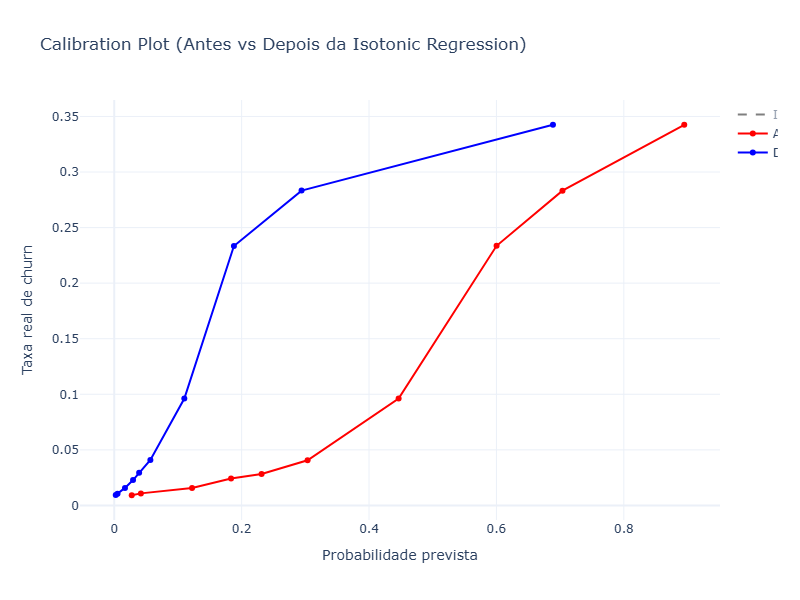

In [22]:
Image('/content/corrige a proba xgb.png')

In [21]:
def threshold_gain_analysis(df, prob_col="p1_calibrated", label_col="churn_m3"):
    # Configurações de negócio
    mensalidade = 149   # valor hipotético
    custo_incentivo = 3 * mensalidade
    ganho_retenção = 12 * mensalidade

    thresholds = np.arange(0.05, 1.0, 0.05)
    results = []

    for t in thresholds:
        df_eval = (
            df.withColumn("predict_offer", (F.col(prob_col) >= F.lit(t)).cast("int"))
        )

        # métricas básicas
        tp = df_eval.filter((F.col(label_col) == 1) & (F.col("predict_offer") == 1)).count()
        fp = df_eval.filter((F.col(label_col) == 0) & (F.col("predict_offer") == 1)).count()
        fn = df_eval.filter((F.col(label_col) == 1) & (F.col("predict_offer") == 0)).count()
        tn = df_eval.filter((F.col(label_col) == 0) & (F.col("predict_offer") == 0)).count()

        # ganhos/perdas
        ganho_tp = 0.5 * tp * (ganho_retenção - custo_incentivo)  # 50% ficam
        perda_tp = 0.5 * tp * (custo_incentivo)                  # 50% não ficam
        perda_fp = fp * custo_incentivo                          # não churn → perda total

        ganho_total = ganho_tp - perda_tp - perda_fp

        results.append((t, tp, fp, fn, tn, ganho_total))

    # Pandas para análise e gráfico
    results_df = pd.DataFrame(results, columns=["threshold", "TP", "FP", "FN", "TN", "gain"])
    return results_df


In [22]:
results_df = threshold_gain_analysis(test_calibrated)

fig = px.line(results_df, x="threshold", y="gain", markers=True,
              title="Ganho financeiro esperado por threshold",
              labels={"threshold": "Threshold", "gain": "Ganho líquido (R$)"})

fig.update_layout(hovermode="x unified",
                    width=800,
                    height=600)
fig.show()

# Melhor threshold
best_row = results_df.loc[results_df["gain"].idxmax()]
print(f"Melhor threshold: {best_row['threshold']:.2f} com ganho esperado de R$ {best_row['gain']:,.2f}")


Melhor threshold: 0.50 com ganho esperado de R$ 2580000.00


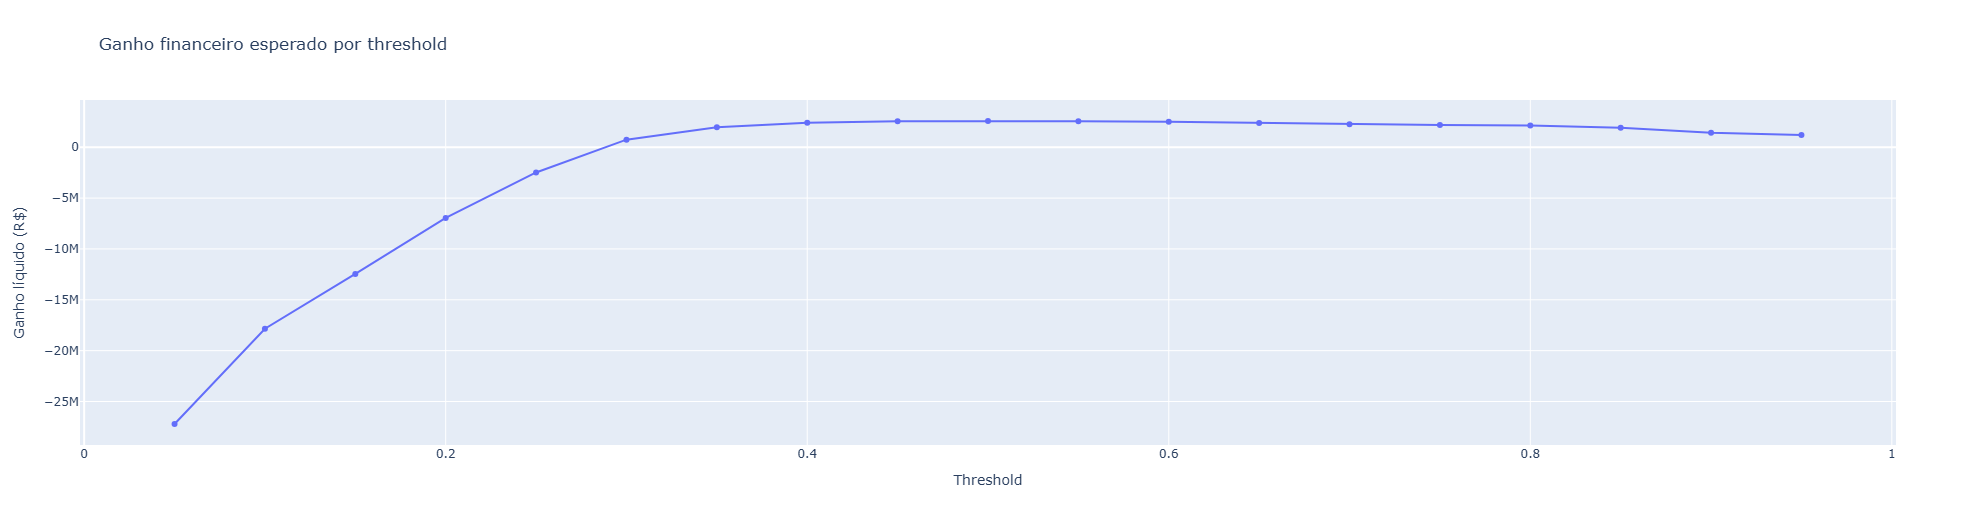

In [32]:
Image('/content/ganho finn treino.png', width=1000, height=600)

In [24]:
results_df = threshold_gain_analysis(oot_calibrated)

fig = px.line(results_df, x="threshold", y="gain", markers=True,
              title="Ganho financeiro esperado por threshold",
              labels={"threshold": "Threshold", "gain": "Ganho líquido (R$)"})

fig.update_layout(hovermode="x unified",
                    width=800,
                    height=600)
fig.show()

# Melhor threshold
best_row = results_df.loc[results_df["gain"].idxmax()]
print(f"Melhor threshold: {best_row['threshold']:.2f} com ganho esperado de R$ {best_row['gain']:.2f}")

Melhor threshold: 0.85 com ganho esperado de R$ 4779300.00


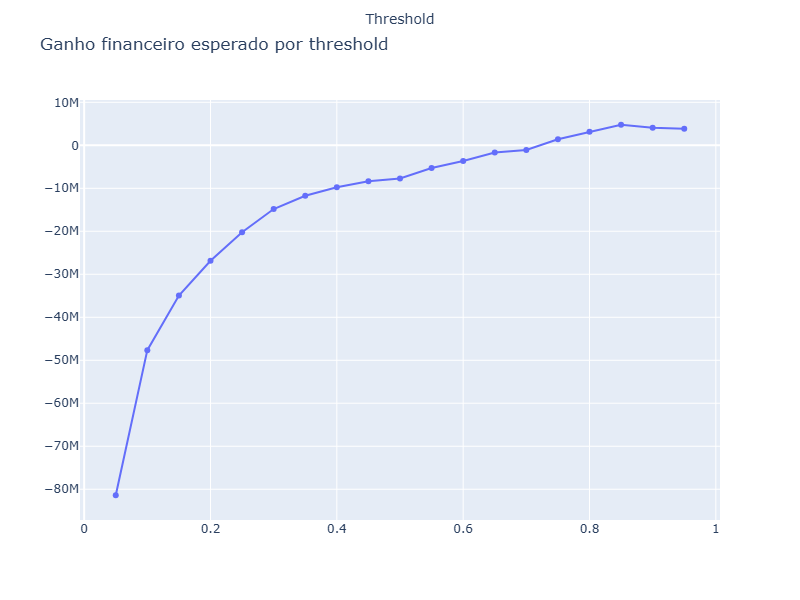

In [24]:
Image('/content/ganho finn oot.png')

# 🔍 Amostras de clientes

Cliente teste 1
- Plano de 425 dias pago em 2015-08-30
- Possui apenas uma transação
- Informação de ativo apenas a partir de 2015-08-23
- A informação de inativo passou a acontecer no mês em que expirou
- A informação dos logs de usuários corresponde ao tempo do plano pago


In [ ]:
filtra_cliente(members_p, 'cbIdNJ0cB3yZpIGyk')

filtra_cliente(transactions_p, 'cbIdNJ0cB3yZpIGyk')

filtra_cliente(user_logs, 'cbIdNJ0cB3yZpIGyk')

+--------------------+------+----------------------+----+---+------+--------------+--------+---------------+--------+------------+
|                msno| safra|registration_init_time|city| bd|gender|registered_via|is_ativo|declared_gender|churn_m3|churn_origem|
+--------------------+------+----------------------+----+---+------+--------------+--------+---------------+--------+------------+
|cbIdNJ0cB3yZpIGyk...|201601|            2015-08-23|   4| 28|  male|             9|       1|              1|       0|           0|
|cbIdNJ0cB3yZpIGyk...|201602|            2015-08-23|   4| 28|  male|             9|       1|              1|       0|           0|
|cbIdNJ0cB3yZpIGyk...|201603|            2015-08-23|   4| 28|  male|             9|       1|              1|       0|           0|
|cbIdNJ0cB3yZpIGyk...|201604|            2015-08-23|   4| 28|  male|             9|       1|              1|       0|           0|
|cbIdNJ0cB3yZpIGyk...|201605|            2015-08-23|   4| 28|  male|             9|

Cliente 2
- As informações de transacionalidade se conversam com o tempo de uso pelo log do usuário, mas não com o tempo da tabela membros. Logo indicando que a tabela membros é uma tabela mais recente, tendo informação apenas de 2016

In [ ]:
filtra_cliente(members_p, '+++snpr7pmobhLKUg')

filtra_cliente(transactions_p, '+++snpr7pmobhLKUg')

filtra_cliente(user_logs, '+++snpr7pmobhLKUg')

+--------------------+------+----------------------+----+---+------+--------------+--------+---------------+--------+------------+
|                msno| safra|registration_init_time|city| bd|gender|registered_via|is_ativo|declared_gender|churn_m3|churn_origem|
+--------------------+------+----------------------+----+---+------+--------------+--------+---------------+--------+------------+
|+++snpr7pmobhLKUg...|201601|            2014-09-27|   1|  0|  NULL|             7|       1|              0|       0|           0|
|+++snpr7pmobhLKUg...|201602|            2014-09-27|   1|  0|  NULL|             7|       1|              0|       0|           0|
|+++snpr7pmobhLKUg...|201603|            2014-09-27|   1|  0|  NULL|             7|       1|              0|       0|           0|
|+++snpr7pmobhLKUg...|201604|            2014-09-27|   1|  0|  NULL|             7|       1|              0|       0|           0|
|+++snpr7pmobhLKUg...|201605|            2014-09-27|   1|  0|  NULL|             7|

In [ ]:
filtra_cliente(members_p, '+7EWrna71aWvaE2b3')

filtra_cliente(transactions_p, '+7EWrna71aWvaE2b3')

filtra_cliente(user_logs, '+7EWrna71aWvaE2b3')

+--------------------+------+----------------------+----+---+------+--------------+--------+---------------+--------+------------+
|                msno| safra|registration_init_time|city| bd|gender|registered_via|is_ativo|declared_gender|churn_m3|churn_origem|
+--------------------+------+----------------------+----+---+------+--------------+--------+---------------+--------+------------+
|+7EWrna71aWvaE2b3...|201606|            2016-06-25|   1|  0|  NULL|             7|       1|              0|       0|           0|
|+7EWrna71aWvaE2b3...|201607|            2016-06-25|   1|  0|  NULL|             7|       1|              0|       0|           0|
|+7EWrna71aWvaE2b3...|201608|            2016-06-25|   1|  0|  NULL|             7|       1|              0|       0|           0|
|+7EWrna71aWvaE2b3...|201609|            2016-06-25|   1|  0|  NULL|             7|       1|              0|       0|           0|
|+7EWrna71aWvaE2b3...|201610|            2016-06-25|   1|  0|  NULL|             7|

In [ ]:
filtra_cliente(members_p, '/KVfvY7VwZDQhWfLo')

filtra_cliente(transactions_p, '/KVfvY7VwZDQhWfLo')

filtra_cliente(user_logs, '/KVfvY7VwZDQhWfLo')



+--------------------+------+----------------------+----+---+------+--------------+--------+---------------+--------+------------+
|                msno| safra|registration_init_time|city| bd|gender|registered_via|is_ativo|declared_gender|churn_m3|churn_origem|
+--------------------+------+----------------------+----+---+------+--------------+--------+---------------+--------+------------+
|/KVfvY7VwZDQhWfLo...|201606|            2016-06-07|   4| 20|  male|             4|       1|              1|       1|           0|
|/KVfvY7VwZDQhWfLo...|201607|            2016-06-07|   4| 20|  male|             4|       1|              1|       1|           0|
|/KVfvY7VwZDQhWfLo...|201608|            2016-06-07|   4| 20|  male|             4|       0|              1|       0|           1|
|/KVfvY7VwZDQhWfLo...|201609|            2016-06-07|   4| 20|  male|             4|       0|              1|       0|           1|
|/KVfvY7VwZDQhWfLo...|201610|            2016-06-07|   4| 20|  male|             4|

In [ ]:
filtra_cliente(members_p, '+1iWwGDvcQcHJweCI')

filtra_cliente(transactions_p, '+1iWwGDvcQcHJweCI')

filtra_cliente(user_logs, '+1iWwGDvcQcHJweCI')

+--------------------+------+----------------------+----+---+------+--------------+--------+---------------+--------+------------+
|                msno| safra|registration_init_time|city| bd|gender|registered_via|is_ativo|declared_gender|churn_m3|churn_origem|
+--------------------+------+----------------------+----+---+------+--------------+--------+---------------+--------+------------+
|+1iWwGDvcQcHJweCI...|201604|            2016-04-08|   6|  0|  NULL|             4|       1|              0|       1|           0|
|+1iWwGDvcQcHJweCI...|201605|            2016-04-08|   6|  0|  NULL|             4|       1|              0|       1|           0|
|+1iWwGDvcQcHJweCI...|201606|            2016-04-08|   6|  0|  NULL|             4|       1|              0|       1|           0|
|+1iWwGDvcQcHJweCI...|201607|            2016-04-08|   6|  0|  NULL|             4|       0|              0|       0|           1|
|+1iWwGDvcQcHJweCI...|201608|            2016-04-08|   6|  0|  NULL|             4|

In [ ]:
members_p.filter(F.col('safra').isin(201606)&F.col('cliente_novo').isin(1)).limit(10).show()

In [ ]:
df_analysis_fe.filter(F.col('is_cancel').isin(1)).limit(10).show()

+--------------------+------+--------+-----------------+----------+---------------+--------------+------------+----------------------+--------+------------+-----------------+---------------+------------------+-------------+---------+-----------+------------------+----------------+----------------------+-------------------------+------------------------+------------------+----------------+----------------------+-------------------------+------------------------+------------------+----------------+----------------------+-------------------------+----------------+----------------------+-------------------------+-----------------------+--------------------------+-----------------------+--------------------------+------+------+------+-------+-------+-------+------------------+---------+------------+------------+------------+------------+-------------+-------------+-------------+--------------+--------------+--------------+-------------------------+----------------+-------------------+------

### testes desnecessários

In [ ]:

# Treinar cada modelo
preproc_model = pipe(full_df_train, dt).fit(full_df_train)

train_dt = preproc_model.transform(full_df_train)
test_dt = preproc_model.transform(full_df_test)

evaluator = BinaryClassificationEvaluator(
  labelCol="churn_m3",
  rawPredictionCol="rawPrediction",
  metricName="areaUnderROC"
  )

auc_train_dt = evaluator.evaluate(test_dt)
auc_test_dt = evaluator.evaluate(test_dt)
# ================================
# 9. Comparação final
# ================================
print("\nResumo dos Modelos:")
print(f"Decision Tree train : {auc_train_dt:.4f}")
print(f"Decision Tree test : {auc_test_dt:.4f}")


# Resumo dos Modelos:
# Decision Tree train : 0.6846
# Decision Tree test : 0.6846


Resumo dos Modelos:
Decision Tree train : 0.6846
Decision Tree test : 0.6846


In [ ]:

# Treinar cada modelo
preproc_model = pipe(full_df_train, rf).fit(full_df_train)

train_rf = preproc_model.transform(full_df_train)
test_rf = preproc_model.transform(full_df_test)

evaluator = BinaryClassificationEvaluator(
  labelCol="churn_m3",
  rawPredictionCol="rawPrediction",
  metricName="areaUnderROC"
  )

auc_train_rf = evaluator.evaluate(test_rf)
auc_test_rf = evaluator.evaluate(test_rf)
# ================================
# 9. Comparação final
# ================================
print("\nResumo dos Modelos:")
print(f"Decision Tree train : {auc_train_rf:.4f}")
print(f"Decision Tree test : {auc_test_rf:.4f}")

# Resumo dos Modelos:
# Decision Tree train : 0.8446
# Decision Tree test : 0.8446


Resumo dos Modelos:
Decision Tree train : 0.8446
Decision Tree test : 0.8446


In [ ]:

xgb_2 = SparkXGBClassifier(
    label_col="churn_m3",          # target
    features_col="features",       # vetor de features
    weight_col="classWeight",      # corrige desbalanceamento
    seed=42,

    # Complexidade do modelo
    num_round=200,                 # número de boosting rounds (similar a numTrees)
    max_depth=6,                  # profundidade máxima das árvores
    min_child_weight=1000,           # tamanho mínimo de amostra em cada folha (similar ao minInstancesPerNode)

    # Regularização / controle de overfitting
    eta=0.05,                       # learning rate → shrinkage
    subsample=0.8,                 # amostragem de linhas
    colsample_bytree=0.8,          # amostragem de colunas

    eval_metric="auc"              # métrica de avaliação (pode trocar para "logloss")
)


In [ ]:
train_xgb, preds_xgb = model_training(xgb_2, pipe, full_df_train, full_df_test)

INFO:XGBoost-PySpark:Running xgboost-3.0.5 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8, 'device': 'cpu', 'eval_metric': 'auc', 'max_depth': 6, 'min_child_weight': 1000, 'subsample': 0.8, 'seed': 42, 'num_round': 200, 'eta': 0.05, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Finished xgboost training!


======== SparkXGBClassifier ========
AUC train : 0.8517
AUC test : 0.8498
------------------------------------------------------------
KS train : 0.5321
KS test : 0.5316
